# **TUIA - Aprendizaje Automático 1 - 2024**

---

**Materia:** Aprendizaje Automático I (IA41)

**Año académico:** 2024

**Período lectivo:** 2° cuatrimestre

**Integrantes:**
- Britos, Julián Francisco
- Menescaldi, Brisa
- Rodriguez y Barros, Francisco 

# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    KFold, 
    StratifiedKFold, 
    cross_val_score
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    RidgeCV,
    ElasticNetCV,
    LassoCV,
    SGDRegressor,
    LogisticRegression
)
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error,
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score, 
    log_loss,
    roc_curve, 
    roc_auc_score, 
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import optuna
import time
from tabulate import tabulate
import pycaret
from pycaret.classification import *
from imblearn.combine import SMOTETomek
import shap

# Carga de datos

In [2]:
weatherdata = pd.read_csv('weatherAUS.csv')

In [3]:
weatherdata

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


# Selección aleatoria de 10 ciudades

In [4]:
# Seleccionamos aleatoriamente 10 ciudades de la columna Location usando una semilla fija
cities = weatherdata['Location'].sample(10, random_state=0)
cities

138175     AliceSprings
38638        WaggaWagga
124058       SalmonGums
99214          Adelaide
25097           Penrith
116391       PearceRAAF
21742     NorfolkIsland
32587            Sydney
111239           Albany
122798            Perth
Name: Location, dtype: object

In [5]:
# Eliminamos todas las ciudades que no sean las pre-selecionadas en la lista cities
weatherdata = weatherdata[weatherdata['Location'].isin(cities)]

# Eliminamos la columna Location ya que para este trabajo consideramos todas las locaciones como una misma
weatherdata = weatherdata.drop(columns='Location')

# Exploración de los datos

Examinaremos los datos para un primer vistazo.

In [6]:
weatherdata

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
21119,2009-01-01,20.4,25.8,0.0,6.0,12.4,NNW,31.0,NNW,NW,...,84.0,71.0,1014.5,1013.6,3.0,1.0,23.3,24.7,No,No
21120,2009-01-02,20.9,26.7,0.2,8.0,10.3,N,31.0,NNE,NE,...,79.0,77.0,1016.3,1015.5,2.0,5.0,25.0,25.1,No,No
21121,2009-01-03,22.3,26.3,0.0,3.2,2.0,E,35.0,ENE,SE,...,87.0,90.0,1014.6,1014.3,7.0,7.0,24.7,23.8,No,Yes
21122,2009-01-04,21.6,22.2,1.2,2.8,0.0,ESE,41.0,ESE,ESE,...,92.0,95.0,1016.0,1015.3,8.0,8.0,22.1,21.2,Yes,Yes
21123,2009-01-05,20.4,23.5,2.6,2.2,2.9,ESE,52.0,ESE,ESE,...,86.0,86.0,1015.3,1013.7,7.0,7.0,21.8,21.6,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139106,2017-06-21,1.6,23.1,0.0,NaN,NaN,ESE,30.0,NaN,SE,...,50.0,26.0,1024.9,1020.5,NaN,NaN,11.3,22.8,No,No
139107,2017-06-22,2.9,25.6,0.0,NaN,NaN,E,26.0,NaN,SE,...,53.0,23.0,1023.9,1019.4,NaN,NaN,11.6,25.1,No,No
139108,2017-06-23,4.1,27.8,0.0,NaN,NaN,N,19.0,NE,N,...,45.0,18.0,1021.4,1017.3,NaN,NaN,15.1,27.2,No,No
139109,2017-06-24,5.0,27.9,0.0,NaN,NaN,SSE,20.0,NaN,WSW,...,35.0,16.0,1019.2,1016.4,NaN,NaN,15.4,27.1,No,No


Hay demaciadas columnas y no se llegan a apreciar todas

In [7]:
weatherdata.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Obtenemos informacion general del dataset

In [8]:
weatherdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30877 entries, 21119 to 139110
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           30877 non-null  object 
 1   MinTemp        30715 non-null  float64
 2   MaxTemp        30728 non-null  float64
 3   Rainfall       30290 non-null  float64
 4   Evaporation    19410 non-null  float64
 5   Sunshine       21474 non-null  float64
 6   WindGustDir    26350 non-null  object 
 7   WindGustSpeed  26351 non-null  float64
 8   WindDir9am     29037 non-null  object 
 9   WindDir3pm     29835 non-null  object 
 10  WindSpeed9am   30641 non-null  float64
 11  WindSpeed3pm   29991 non-null  float64
 12  Humidity9am    30636 non-null  float64
 13  Humidity3pm    29996 non-null  float64
 14  Pressure9am    24752 non-null  float64
 15  Pressure3pm    24752 non-null  float64
 16  Cloud9am       19370 non-null  float64
 17  Cloud3pm       18643 non-null  float64
 18  Temp9a

El dataset cuenta con 30877 registros.

Solamente `Date` tiene todos sus valores completos, ya que en cada una el conteo de valores no nulos de las demas caracteristicas es menor que el total.

In [9]:
# Valores faltantes en el dataset
weatherdata.isnull().sum()

Date                 0
MinTemp            162
MaxTemp            149
Rainfall           587
Evaporation      11467
Sunshine          9403
WindGustDir       4527
WindGustSpeed     4526
WindDir9am        1840
WindDir3pm        1042
WindSpeed9am       236
WindSpeed3pm       886
Humidity9am        241
Humidity3pm        881
Pressure9am       6125
Pressure3pm       6125
Cloud9am         11507
Cloud3pm         12234
Temp9am            147
Temp3pm            807
RainToday          587
RainTomorrow       589
dtype: int64

In [10]:
weatherdata.describe(include='all')

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,30877,30715.000000,30728.000000,30290.000000,19410.000000,21474.000000,26350,26351.000000,29037,29835,...,30636.000000,29996.00000,24752.000000,24752.000000,19370.000000,18643.000000,30730.000000,30070.000000,30290,30288
unique,3344,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2009-01-01,NaN,NaN,NaN,NaN,NaN,E,NaN,E,SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,10,NaN,NaN,NaN,NaN,NaN,2458,NaN,3222,2850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23917,23917
mean,NaN,12.743708,24.013148,1.980865,5.663776,8.014562,NaN,38.525065,NaN,NaN,...,64.273796,47.62805,1017.957999,1015.564564,4.066391,4.102451,17.850088,22.656751,NaN,NaN
std,NaN,5.700223,6.569885,6.577661,4.131155,3.756950,NaN,12.460749,NaN,NaN,...,20.212237,21.22657,6.745881,6.644922,2.880685,2.717290,5.716287,6.435339,NaN,NaN
min,NaN,-5.200000,6.300000,0.000000,0.000000,0.000000,NaN,7.000000,NaN,NaN,...,1.000000,1.00000,980.500000,979.000000,0.000000,0.000000,0.000000,6.000000,NaN,NaN
25%,NaN,8.800000,19.100000,0.000000,2.800000,5.500000,NaN,30.000000,NaN,NaN,...,52.000000,31.00000,1013.400000,1011.000000,1.000000,1.000000,13.700000,17.900000,NaN,NaN
50%,NaN,13.100000,22.900000,0.000000,4.800000,9.000000,NaN,37.000000,NaN,NaN,...,66.000000,48.00000,1018.000000,1015.600000,4.000000,4.000000,17.800000,21.600000,NaN,NaN
75%,NaN,17.000000,28.000000,0.600000,7.600000,10.900000,NaN,46.000000,NaN,NaN,...,80.000000,63.00000,1022.600000,1020.100000,7.000000,7.000000,21.600000,26.500000,NaN,NaN


Vemos que hay algunas columnas que puede que tengan outlier como `Evaporation` o `WindGustSpeed`

# Split de datos en Train y test

## Datos faltantes

In [11]:
# Contar el número de columnas nulas por fila
nulos_por_fila = weatherdata.isnull().sum(axis=1)

# Contar el número de registros que tienen 10 o más columnas nulas
registros_con_10_o_mas_nulos = (nulos_por_fila >= 10).sum()

registros_con_10_o_mas_nulos

274

En nuestro dataset encontramos 274 registros que tienen 10 o mas valores nulos, en un total de 22 columnas.

Respecto al total de observaciones (30877) las que tienen 10 o mas valores nulos (274) representan aproximadamente un 0,89% del dataset, por lo que vamos a eliminarlas por completo.

In [12]:
weatherdata = weatherdata[weatherdata.isnull().sum(axis=1) < 10]

## Split en X e Y

In [13]:
X = weatherdata.drop(columns=['RainTomorrow'])
y = weatherdata["RainTomorrow"]

## X_train, X_test, y_train, y_test

Dividimos el set de datos en train y test antes de realizar la imputación de nulos para evitar la generación de un data leakage.

Esto lo hacemos a través de la fecha, ya que de este modo podemos mantener la integridad temporal de nuestros datos. Al dividir los datos en conjuntos de entrenamiento y prueba basándonos en una fecha específica, estamos respetando el orden cronológico de los eventos. Esto es especialmente importante en series temporales y en problemas donde la secuencia y la temporalidad importan.

Por otro lado, si utilizáramos train_test_split de manera aleatoria, podríamos terminar con datos de prueba que se filtraron en el conjunto de entrenamiento después de la imputación. Esto podría llevar a un modelo sobreajustado que funciona bien en los datos de entrenamiento, pero falla al generalizar en datos nuevos o futuros.

In [14]:
# Convierto la columna 'Date' a tipo datetime utilizando .loc para evitar el warning
weatherdata.loc[:, "Date"] = pd.to_datetime(weatherdata["Date"])
X.loc[:, "Date"] = pd.to_datetime(X["Date"])

In [15]:
# Mostrar la primera y última fecha
primera_fecha = weatherdata['Date'].min()
ultima_fecha = weatherdata['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = weatherdata['Date'].quantile(0.8)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)


Primera fecha: 2008-02-01 00:00:00
Última fecha: 2017-06-25 00:00:00
Fecha que abarca el 80% de los datos: 2015-10-13 00:00:00


In [16]:
# Dividir X e y en conjuntos de entrenamiento y prueba basados en la fecha
X_train = X[X['Date'] <= fecha_80porciento].drop(columns='Date')
X_test = X[X['Date'] > fecha_80porciento].drop(columns='Date')
y_train = y[X['Date'] <= fecha_80porciento]
y_test = y[X['Date'] > fecha_80porciento]

# Visualización de los datos

## Matriz de correlación de variable continuas

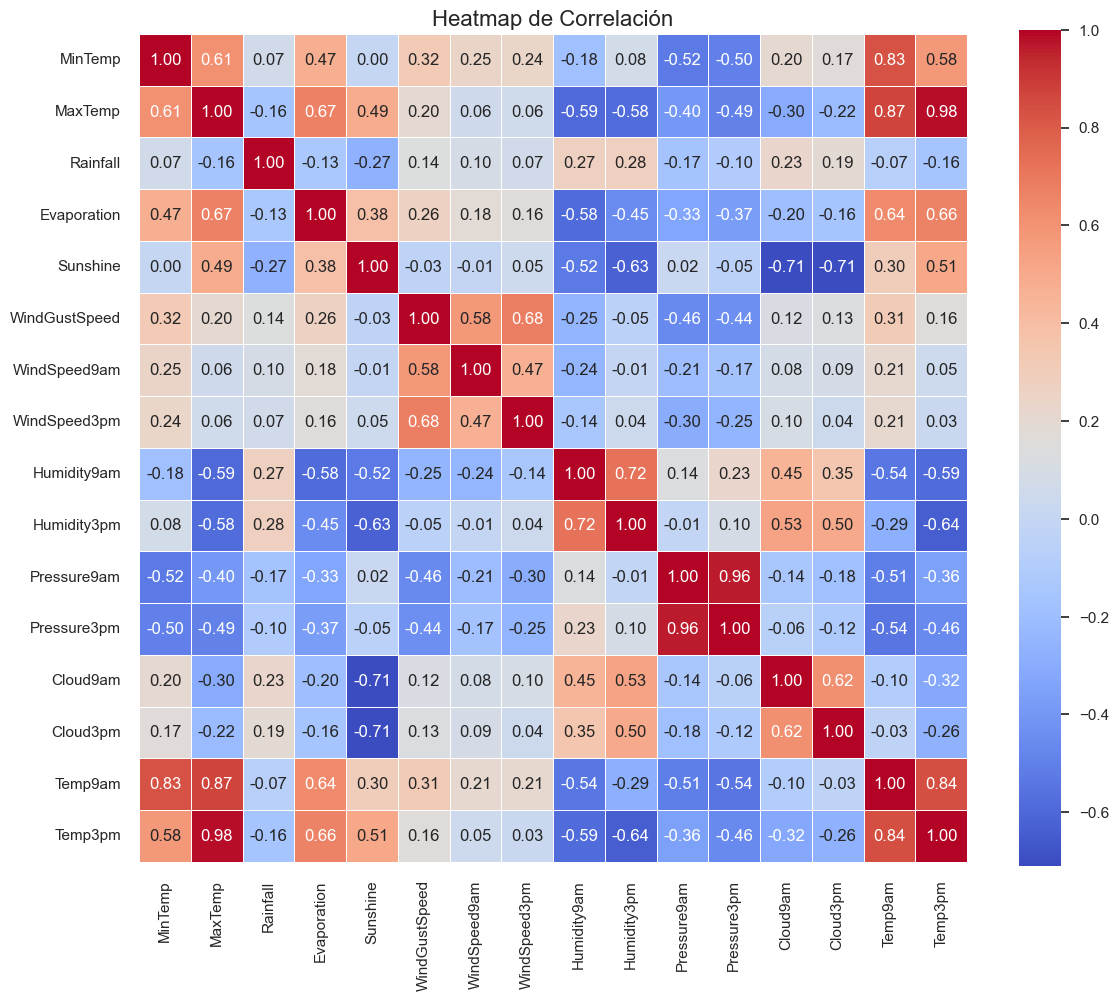

In [17]:
variables = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 
       'Temp9am', 'Temp3pm']

weatherdata_subset = weatherdata[variables]

# Calcular la correlación entre las variables
correlation = weatherdata_subset.corr()

sns.set_theme()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Heatmap de Correlación', fontsize=16)
plt.tight_layout()
plt.show()

### Análisis de correlación entre variables

##### Correlaciones altas identificadas (≥ 0.70):

1. **MaxTemp y Temp3pm** (0.98):
   - Existe una correlación positiva extremadamente fuerte entre la temperatura máxima del día y la temperatura a las 3pm.
   - Esto sugiere que la temperatura máxima diaria típicamente ocurre cerca de las 3pm, lo cual es consistente con el ciclo diario normal de temperatura.

2. **Pressure9am y Pressure3pm** (0.96):
   - Hay una correlación positiva muy fuerte entre la presión atmosférica medida a las 9am y a las 3pm.
   - Indica que los cambios de presión atmosférica son graduales y mantienen una consistencia a lo largo del día.

3. **Temp9am y MaxTemp** (0.87):
   - Se observa una fuerte correlación positiva entre la temperatura de la mañana y la temperatura máxima del día.
   - Esto podría ser útil para predicciones tempranas de las temperaturas máximas diarias.

4. **Temp9am y Temp3pm** (0.84):
   - La correlación positiva fuerte entre las temperaturas de la mañana y la tarde indica un patrón predecible en el ciclo diario de temperatura.

5. **Humidity9am y Humidity3pm** (0.72):
   - La humedad relativa muestra una correlación positiva fuerte entre las mediciones de la mañana y la tarde.
   - Sugiere cierta estabilidad en los niveles de humedad durante el día.

##### Correlaciones negativas significativas:

1. **Cloud9am y Sunshine** (-0.71):
   - La fuerte correlación negativa entre la nubosidad y las horas de sol es lógica y esperada.
   - Confirma que la cobertura nubosa es un factor determinante en la cantidad de luz solar recibida.
2. **Cloud3pm y Sunshine** (-0.71):
   - La fuerte correlación negativa entre la nubosidad y las horas de sol es lógica y esperada.
   - Confirma que la cobertura nubosa es un factor determinante en la cantidad de luz solar recibida.
##### Nota

Realizaremos las siguientes visualizaciones de aquellas variables cuya correlación sea alta para ver cómo se comportan juntas de una forma más gráfica, ya que estos valores "altos" que nos dieron solo nos indican la fuerza y dirección de la relación lineal entre las variables, pero no nos muestran la forma exacta de la relación (podría ser no lineal).

## MaxTemp y Temp3pm

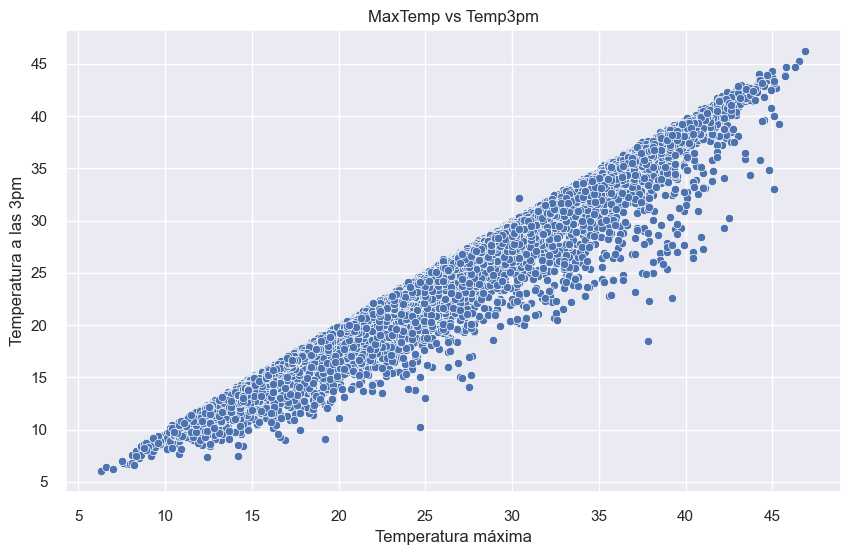

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='MaxTemp', y='Temp3pm')
plt.title('MaxTemp vs Temp3pm')
plt.xlabel('Temperatura máxima')
plt.ylabel('Temperatura a las 3pm')
plt.show()

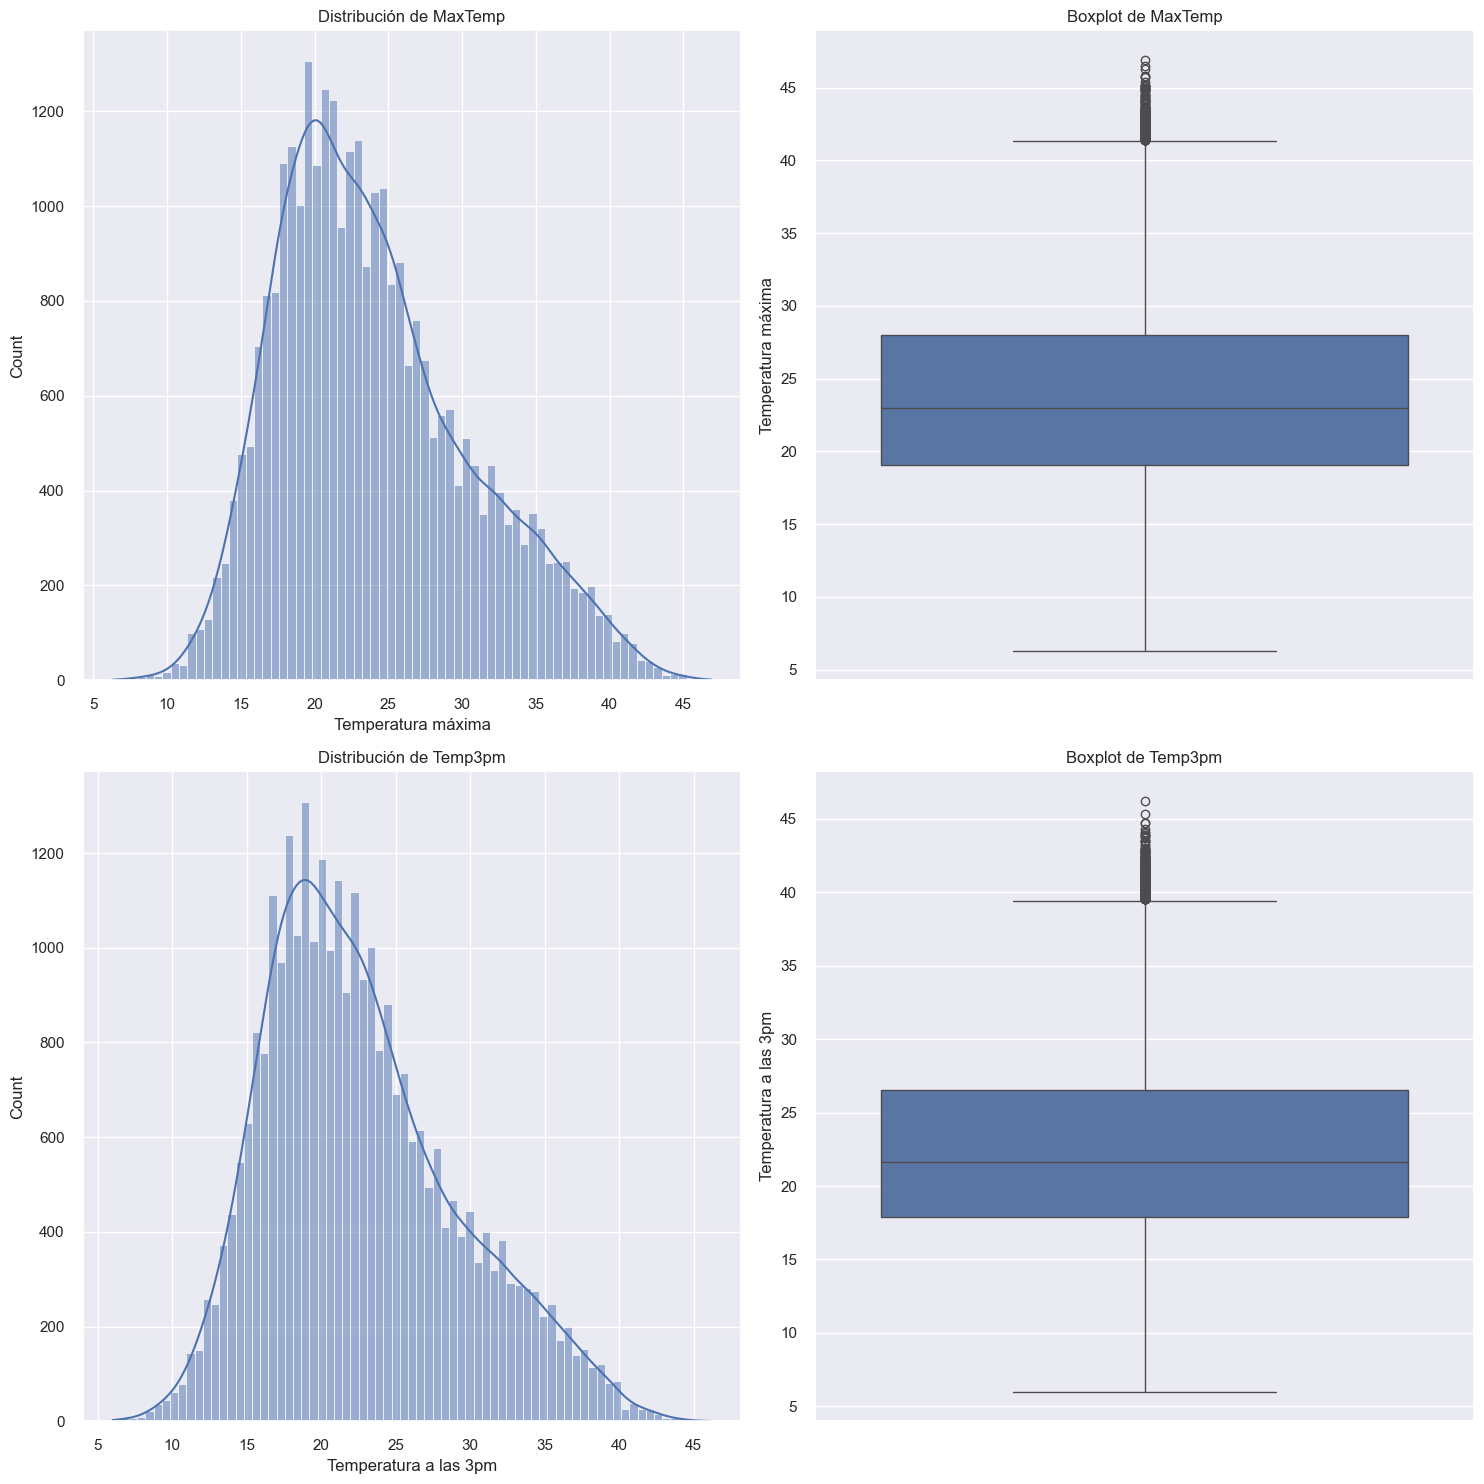

In [19]:
plt.figure(figsize=(15, 15))

# Histograma de MaxTemp
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['MaxTemp'], kde=True)
plt.title('Distribución de MaxTemp')
plt.xlabel('Temperatura máxima')

# Boxplot de MaxTemp
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['MaxTemp'])
plt.title('Boxplot de MaxTemp')
plt.ylabel('Temperatura máxima')

# Histograma de Temp3pm
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Temp3pm'], kde=True)
plt.title('Distribución de Temp3pm')
plt.xlabel('Temperatura a las 3pm')

# Boxplot de Temp3pm
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Temp3pm'])
plt.title('Boxplot de Temp3pm')
plt.ylabel('Temperatura a las 3pm')

plt.tight_layout()
plt.show()

**MaxTemp:** El histograma muestra una distribución ligeramente sesgada a la derecha, con una mayor concentración de valores entre los 15 y 30 grados. Hay algunos valores más altos pero menos frecuentes.
El boxplot indica la presencia de valores atípicos (outliers) por encima de los 40 grados, pero la mayor parte de los datos se concentra entre los 20 y 30 grados.

**Temp3pm:** La distribución de "Temp3pm" es muy similar a "MaxTemp", también asimétrica positiva con una mayor densidad de valores entre los 15 y 30 grados.

Dado a que la correlacion entre ambas variables es muy fuerte (0.98) vamos a imputar los valores nulos de ambas usando una **Regresión Lineal.**

In [20]:
# Imputación de MaxTemp usando Temp3pm
# Entrenar el modelo en X_train
max_temp_model = LinearRegression()
train_not_null = X_train.dropna(subset=['MaxTemp', 'Temp3pm'])
max_temp_model.fit(train_not_null[['Temp3pm']], train_not_null['MaxTemp'])

# Imputar valores nulos en X_train solo cuando Temp3pm no es NaN
train_null_max_temp = X_train[X_train['MaxTemp'].isnull() & X_train['Temp3pm'].notnull()]
X_train.loc[train_null_max_temp.index, 'MaxTemp'] = max_temp_model.predict(train_null_max_temp[['Temp3pm']])

# Imputar valores nulos en X_test solo cuando Temp3pm no es NaN
test_null_max_temp = X_test[X_test['MaxTemp'].isnull() & X_test['Temp3pm'].notnull()]
X_test.loc[test_null_max_temp.index, 'MaxTemp'] = max_temp_model.predict(test_null_max_temp[['Temp3pm']])

# Imputación de Temp3pm usando MaxTemp
# Entrenar el modelo en X_train
temp3pm_model = LinearRegression()
train_not_null = X_train.dropna(subset=['Temp3pm', 'MaxTemp'])  # Filtramos los datos no nulos
temp3pm_model.fit(train_not_null[['MaxTemp']], train_not_null['Temp3pm'])

# Imputar valores nulos en X_train solo cuando MaxTemp no es NaN
train_null_temp3pm = X_train[X_train['Temp3pm'].isnull() & X_train['MaxTemp'].notnull()]
X_train.loc[train_null_temp3pm.index, 'Temp3pm'] = temp3pm_model.predict(train_null_temp3pm[['MaxTemp']])

# Imputar valores nulos en X_test solo cuando MaxTemp no es NaN
test_null_temp3pm = X_test[X_test['Temp3pm'].isnull() & X_test['MaxTemp'].notnull()]
X_test.loc[test_null_temp3pm.index, 'Temp3pm'] = temp3pm_model.predict(test_null_temp3pm[['MaxTemp']])

# Imputar valores faltantes restantes con la mediana en caso de que ambas variables tengan NaN
X_train['MaxTemp'] = X_train['MaxTemp'].fillna(X_train['MaxTemp'].median())
X_train['Temp3pm'] = X_train['Temp3pm'].fillna(X_train['Temp3pm'].median())
X_test['MaxTemp'] = X_test['MaxTemp'].fillna(X_test['MaxTemp'].median())
X_test['Temp3pm'] = X_test['Temp3pm'].fillna(X_test['Temp3pm'].median())


## Temp9am, MaxTemp y MinTemp

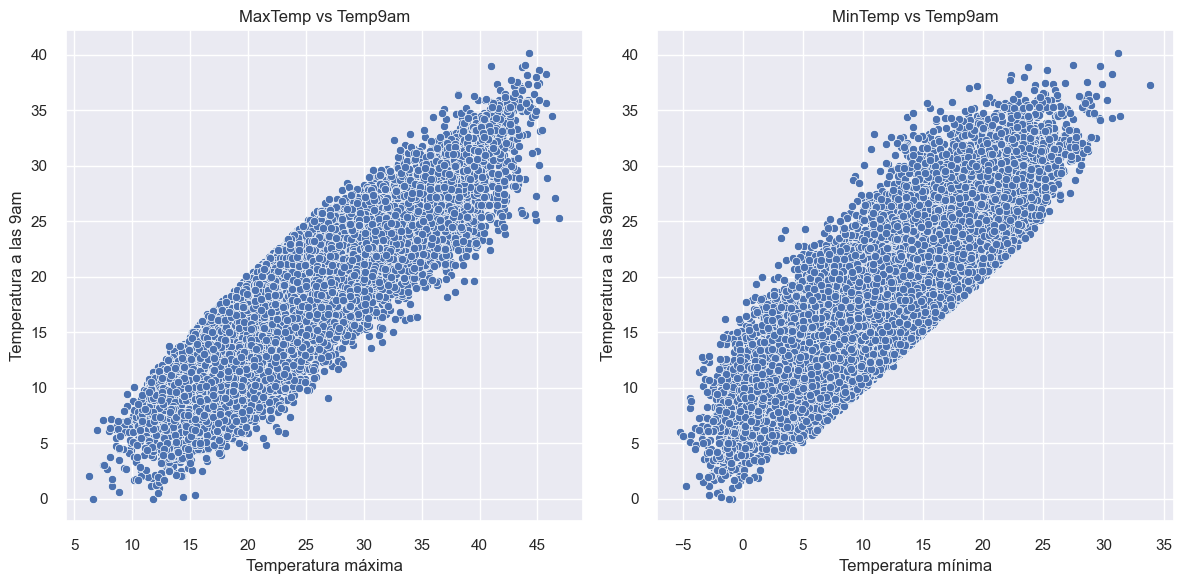

In [21]:
# Crear la figura
plt.figure(figsize=(12, 6))

# Primer gráfico: MaxTemp vs Temp9am
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
sns.scatterplot(data=weatherdata, x='MaxTemp', y='Temp9am')
plt.title('MaxTemp vs Temp9am')
plt.xlabel('Temperatura máxima')
plt.ylabel('Temperatura a las 9am')

# Segundo gráfico: MinTemp vs Temp9am
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
sns.scatterplot(data=weatherdata, x='MinTemp', y='Temp9am')
plt.title('MinTemp vs Temp9am')
plt.xlabel('Temperatura mínima')
plt.ylabel('Temperatura a las 9am')

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()

Temp9am tiene una fuerte correlación con MaxTemp (0.87) y MinTemp (0.83). Para imputar los valores nulos, primero utilizaremos una regresión lineal entrenada con MaxTemp para completar los valores faltantes de Temp9am. Luego, utilizaremos otra regresión lineal entrenada con Temp9am para imputar los valores nulos de MinTemp.

In [22]:
# Imputación de Temp9am usando MaxTemp
# Entrenar el modelo en X_train
temp9am_model = LinearRegression()
train_not_null = X_train.dropna(subset=['Temp9am', 'MaxTemp'])
temp9am_model.fit(train_not_null[['MaxTemp']], train_not_null['Temp9am'])

# Imputar valores nulos en X_train solo cuando Temp3pm no es NaN
train_null_max_temp = X_train[X_train['Temp9am'].isnull() & X_train['MaxTemp'].notnull()]
X_train.loc[train_null_max_temp.index, 'Temp9am'] = temp9am_model.predict(train_null_max_temp[['MaxTemp']])

# Imputar valores nulos en X_test solo cuando Temp3pm no es NaN
test_null_max_temp = X_test[X_test['Temp9am'].isnull() & X_test['MaxTemp'].notnull()]
X_test.loc[test_null_max_temp.index, 'Temp9am'] = temp9am_model.predict(test_null_max_temp[['MaxTemp']])


# Imputación de MinTemp usando Temp9am
# Entrenar el modelo en X_train
MinTemp_model = LinearRegression()
train_not_null = X_train.dropna(subset=['MinTemp', 'Temp9am'])
MinTemp_model.fit(train_not_null[['Temp9am']], train_not_null['MinTemp'])

# Imputar valores nulos en X_train solo cuando Temp3pm no es NaN
train_null_max_temp = X_train[X_train['MinTemp'].isnull() & X_train['Temp9am'].notnull()]
X_train.loc[train_null_max_temp.index, 'MinTemp'] = MinTemp_model.predict(train_null_max_temp[['Temp9am']])

# Imputar valores nulos en X_test solo cuando Temp3pm no es NaN
test_null_max_temp = X_test[X_test['MinTemp'].isnull() & X_test['Temp9am'].notnull()]
X_test.loc[test_null_max_temp.index, 'MinTemp'] = MinTemp_model.predict(test_null_max_temp[['Temp9am']])

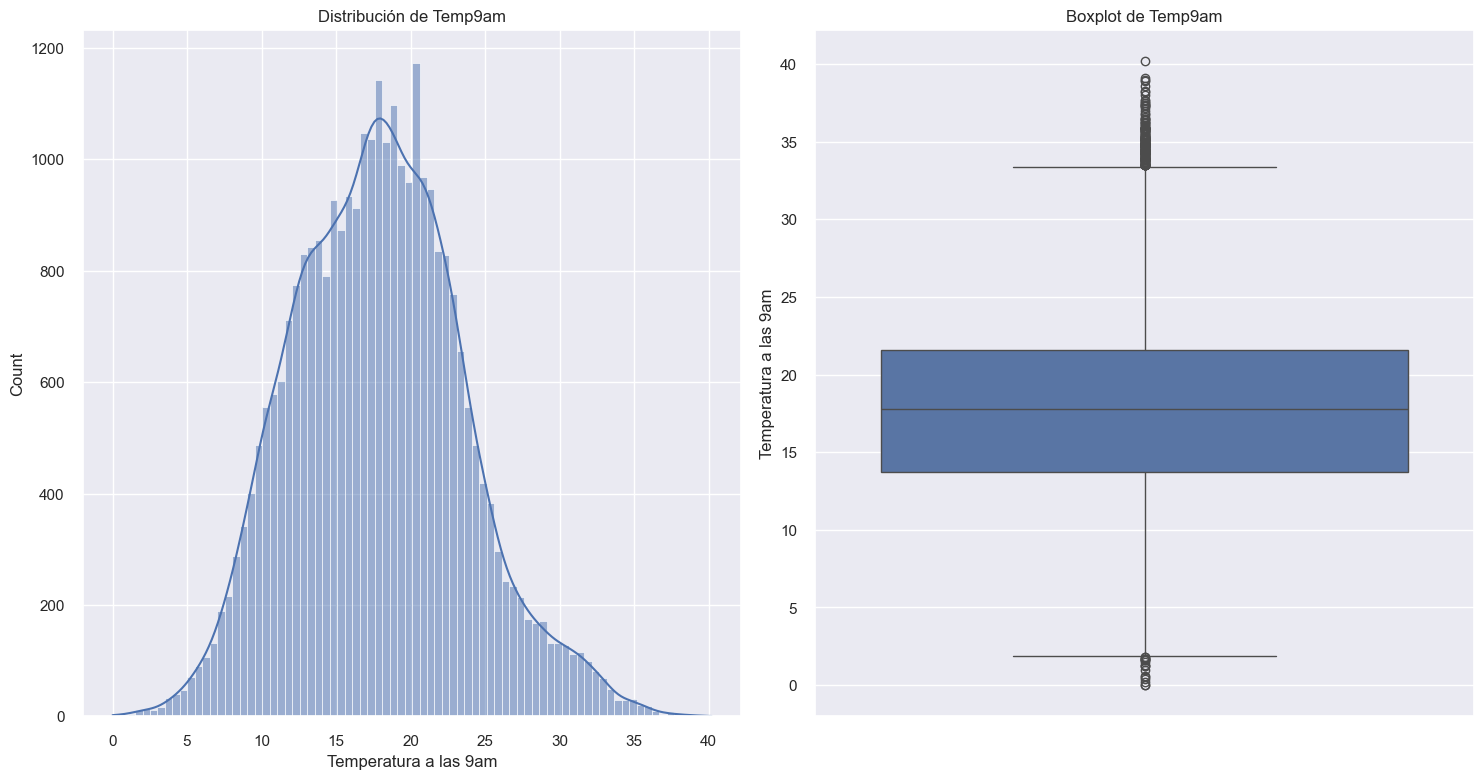

In [23]:
# Histograma de Temp9am
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Temp9am'], kde=True)
plt.title('Distribución de Temp9am')
plt.xlabel('Temperatura a las 9am')

# Boxplot de Temp9am
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Temp9am'])
plt.title('Boxplot de Temp9am')
plt.ylabel('Temperatura a las 9am')

plt.tight_layout()
plt.show()

## Humidity9am y Humidity3pm

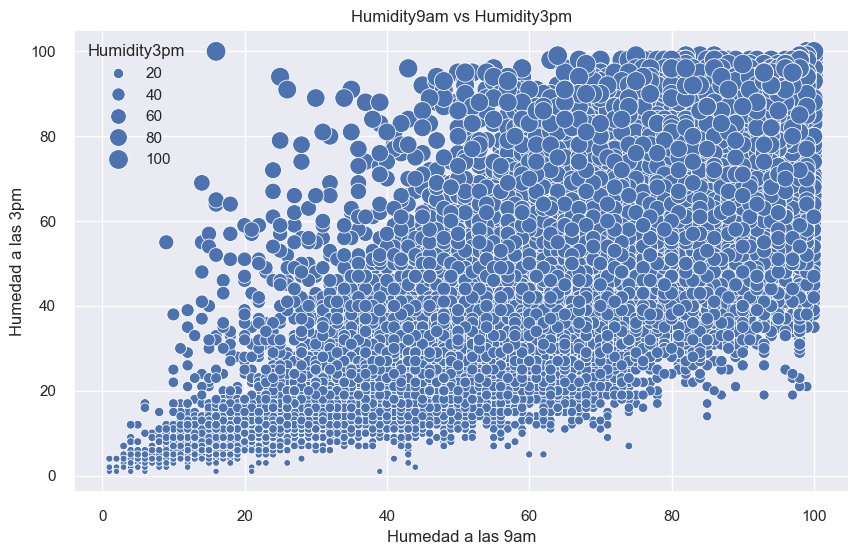

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='Humidity9am', y='Humidity3pm', size='Humidity3pm', sizes=(20, 200))
plt.title('Humidity9am vs Humidity3pm')
plt.xlabel('Humedad a las 9am')
plt.ylabel('Humedad a las 3pm')
plt.show()

Las variables Humidity9am y Humidity3pm están moderadamente correlacionadas, lo que indica que es razonable suponer que una puede ser predictiva de la otra, aunque con algunas excepciones, especialmente en los valores más bajos de humedad.

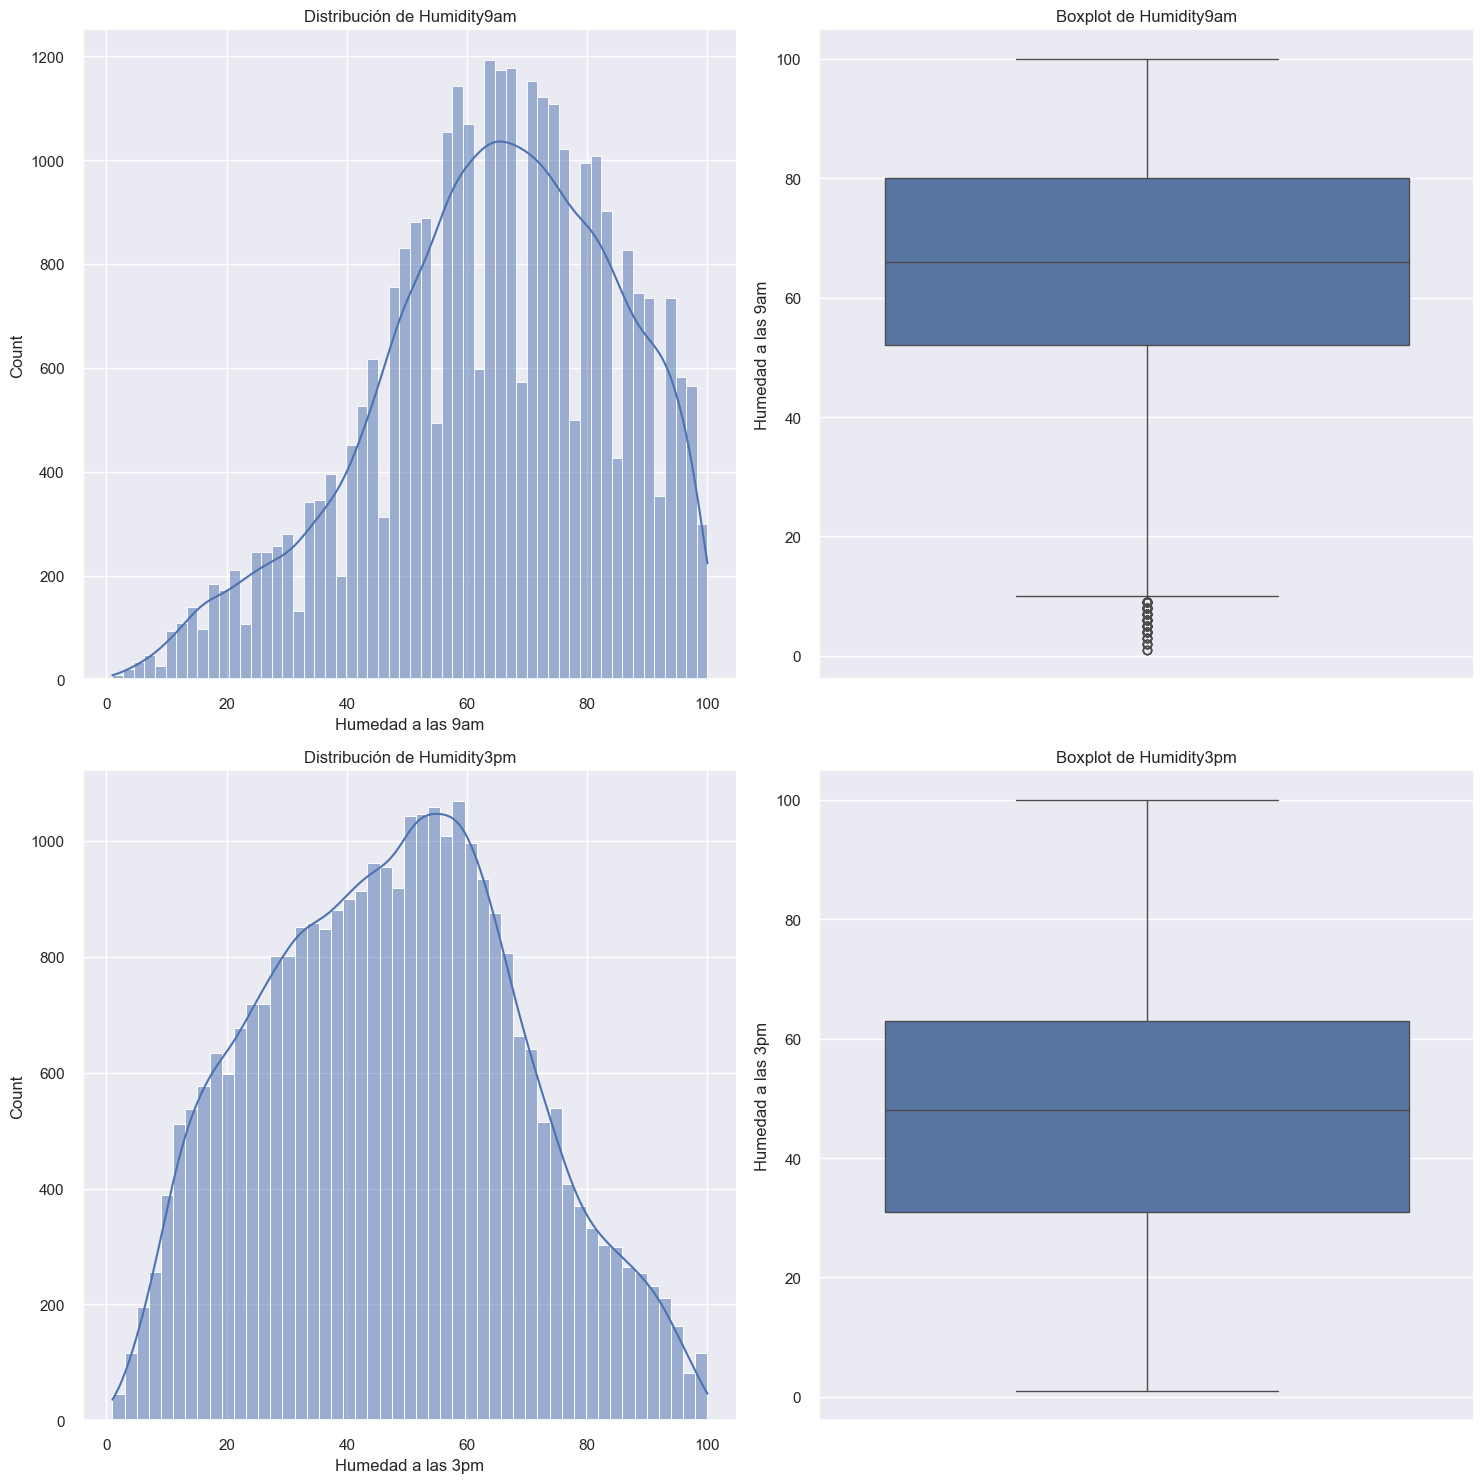

In [25]:
plt.figure(figsize=(15, 15))

# Histograma de Humidity9am
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['Humidity9am'], kde=True)
plt.title('Distribución de Humidity9am')
plt.xlabel('Humedad a las 9am')

# Boxplot de Humidity9am
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['Humidity9am'])
plt.title('Boxplot de Humidity9am')
plt.ylabel('Humedad a las 9am')

# Histograma de Humidity3pm
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Humidity3pm'], kde=True)
plt.title('Distribución de Humidity3pm')
plt.xlabel('Humedad a las 3pm')

# Boxplot de Humidity3pm
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Humidity3pm'])
plt.title('Boxplot de Humidity3pm')
plt.ylabel('Humedad a las 3pm')

plt.tight_layout()
plt.show()

**Humidity9am:** La humedad a las 9 am suele ser alta, con la mayoría de los días entre 60% y 90%. Sin embargo, hay algunos días con niveles de humedad realmente bajos, lo que genera algunos outliers en la parte baja.

**Humidity3m:** La humedad a las 3 pm tiende a ser más uniforme, concentrándose alrededor del 50%. A esta hora del día, la variabilidad es menor en comparación con la mañana, y los días extremadamente húmedos son menos comunes.

Ambas variables muestran que la humedad tiende a disminuir a lo largo del día.

Decidimos usar la mediana porque es más resistente a los valores extremos y asimetrías. 

In [26]:
# Calcular la mediana solo con los valores de train
mediana_humidity9am_train = X_train['Humidity9am'].median()
X_train['Humidity9am'] = X_train['Humidity9am'].fillna(mediana_humidity9am_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Humidity9am'] = X_test['Humidity9am'].fillna(mediana_humidity9am_train)

# Calcular la mediana solo con los valores de train
mediana_Humidity3pm_train = X_train['Humidity3pm'].median()
X_train['Humidity3pm'] = X_train['Humidity3pm'].fillna(mediana_Humidity3pm_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Humidity3pm'] = X_test['Humidity3pm'].fillna(mediana_Humidity3pm_train)

## Pressure9am y Pressure3pm

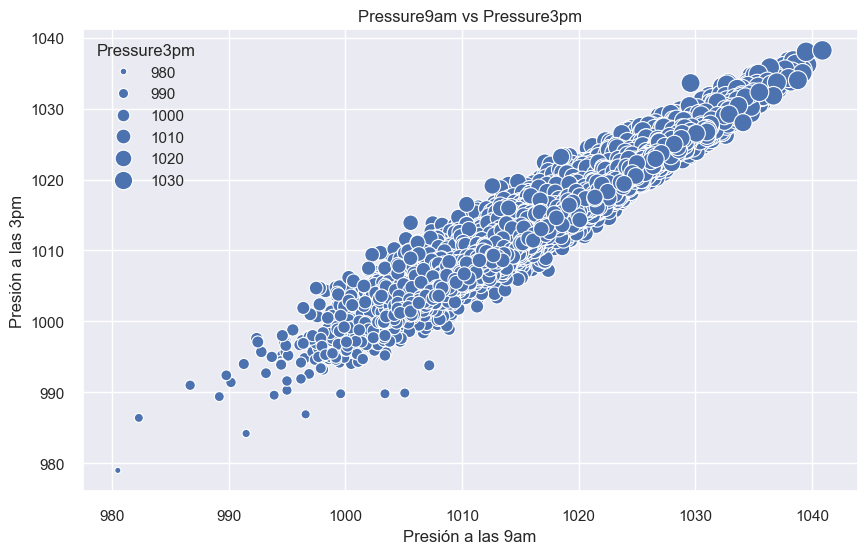

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weatherdata, x='Pressure9am', y='Pressure3pm', size='Pressure3pm', sizes=(20, 200))
plt.title('Pressure9am vs Pressure3pm')
plt.xlabel('Presión a las 9am')
plt.ylabel('Presión a las 3pm')
plt.show()

La fuerte correlación entre Pressure9am y Pressure3pm (0.96) tiene sentido porque la presión atmosférica normalmente cambia de forma gradual durante el día. En condiciones normales, no suelen ocurrir variaciones bruscas entre la mañana y la tarde, salvo que haya un evento climático importante, como una tormenta. 

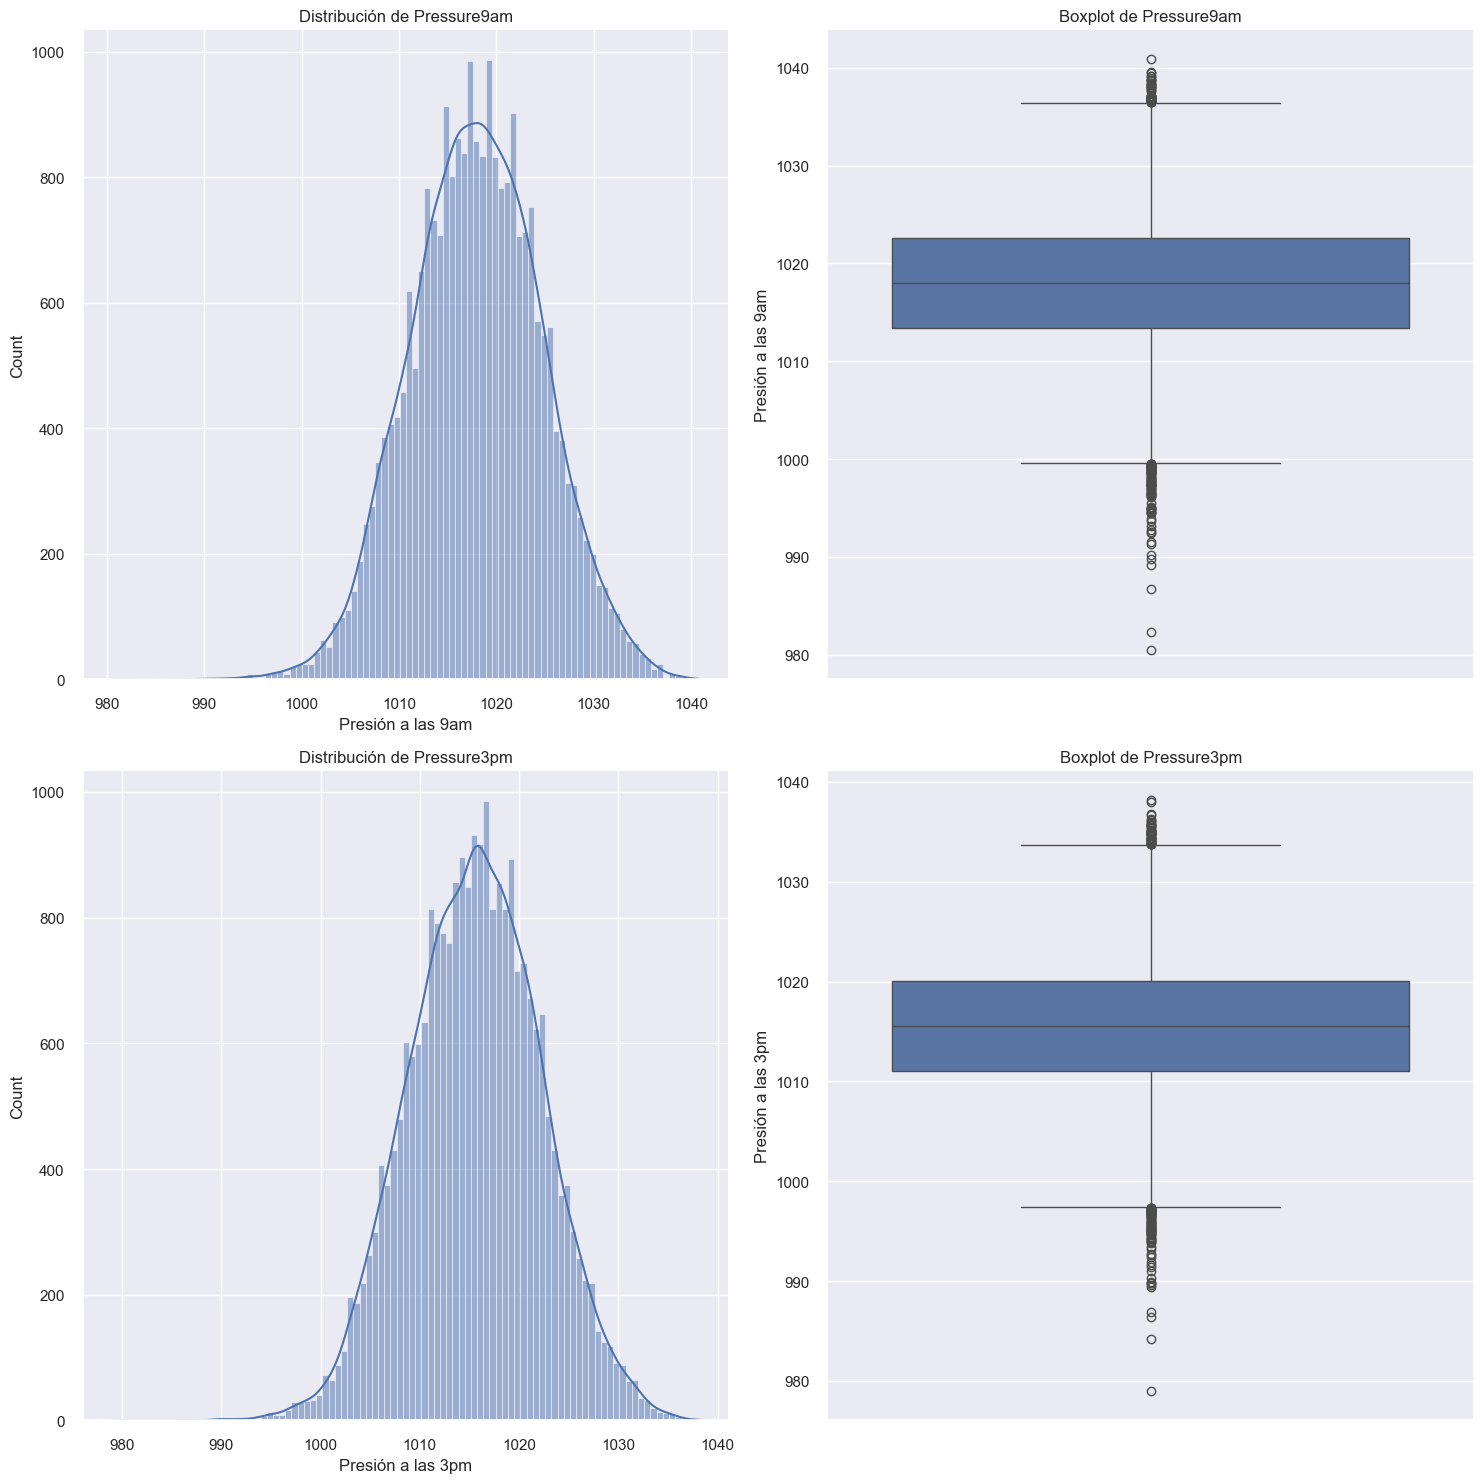

In [28]:
plt.figure(figsize=(15, 15))

# Histograma de Pressure9am
plt.subplot(2, 2, 1)
sns.histplot(weatherdata['Pressure9am'], kde=True)
plt.title('Distribución de Pressure9am')
plt.xlabel('Presión a las 9am')

# Boxplot de Pressure9am
plt.subplot(2, 2, 2)
sns.boxplot(y=weatherdata['Pressure9am'])
plt.title('Boxplot de Pressure9am')
plt.ylabel('Presión a las 9am')

# Histograma de Pressure3pm
plt.subplot(2, 2, 3)
sns.histplot(weatherdata['Pressure3pm'], kde=True)
plt.title('Distribución de Pressure3pm')
plt.xlabel('Presión a las 3pm')

# Boxplot de Pressure3pm
plt.subplot(2, 2, 4)
sns.boxplot(y=weatherdata['Pressure3pm'])
plt.title('Boxplot de Pressure3pm')
plt.ylabel('Presión a las 3pm')

plt.tight_layout()
plt.show()

Las distribuciones de Pressure9am y Pressure3pm son muy parecidas, con una ligera asimetría y algunos outliers. En general, siguen un patrón similar, lo que confirma que la correlación entre ellas es fuerte y tiene sentido, como muestra el valor de 0.96.

Dado a la fuerte correlacion entre ambas variables podriamos usar un modelo de Regresión Lineal para imputar valores faltantes como lo hicimos anteriormente, sin embargo,
Observamos que en nuestro dataset hay 4.715 valores nulos en Pressure9am y 4.711 en Pressure3pm, y en la mayoría de los casos (4,684) ambas columnas son nulas al mismo tiempo. Solo hay alrededor de 30 casos donde falta una de las dos, por lo que estariamos imputando solamente al rededor de 30 observaciones con el modelo de regresion lineal.

 Por eso, optamos por imputar todos los valores nulos usando la mediana, ya que hacer una regresión lineal para tan pocos registros no tiene mucho sentido y la mediana nos da una solución simple y efectiva.

In [29]:
# Calcular la mediana solo con los valores de train
mediana_Pressure9am_train = X_train['Pressure9am'].median()
X_train['Pressure9am'] = X_train['Pressure9am'].fillna(mediana_Pressure9am_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Pressure9am'] = X_test['Pressure9am'].fillna(mediana_Pressure9am_train)

# Calcular la mediana solo con los valores de train
mediana_Pressure3pm_train = X_train['Pressure3pm'].median()
X_train['Pressure3pm'] = X_train['Pressure3pm'].fillna(mediana_Pressure3pm_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Pressure3pm'] = X_test['Pressure3pm'].fillna(mediana_Pressure3pm_train)

## Sunshine, Cloud9am y Cloud3pm

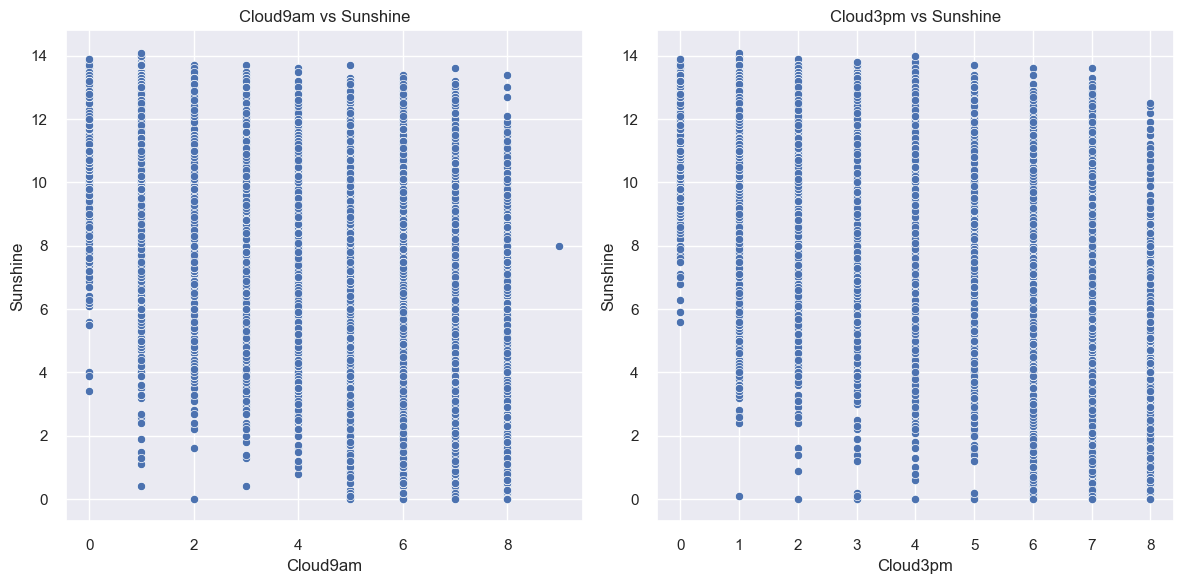

In [30]:
# Crear la figura
plt.figure(figsize=(12, 6))

# Primer gráfico: Cloud9am vs Sunshine
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
sns.scatterplot(data=weatherdata, x='Cloud9am', y='Sunshine')
plt.title('Cloud9am vs Sunshine')
plt.xlabel('Cloud9am')
plt.ylabel('Sunshine')

# Segundo gráfico: Cloud3pm vs Sunshine
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
sns.scatterplot(data=weatherdata, x='Cloud3pm', y='Sunshine')
plt.title('Cloud3pm vs Sunshine')
plt.xlabel('Cloud3pm')
plt.ylabel('Sunshine')

# Mostrar ambos gráficos
plt.tight_layout()
plt.show()

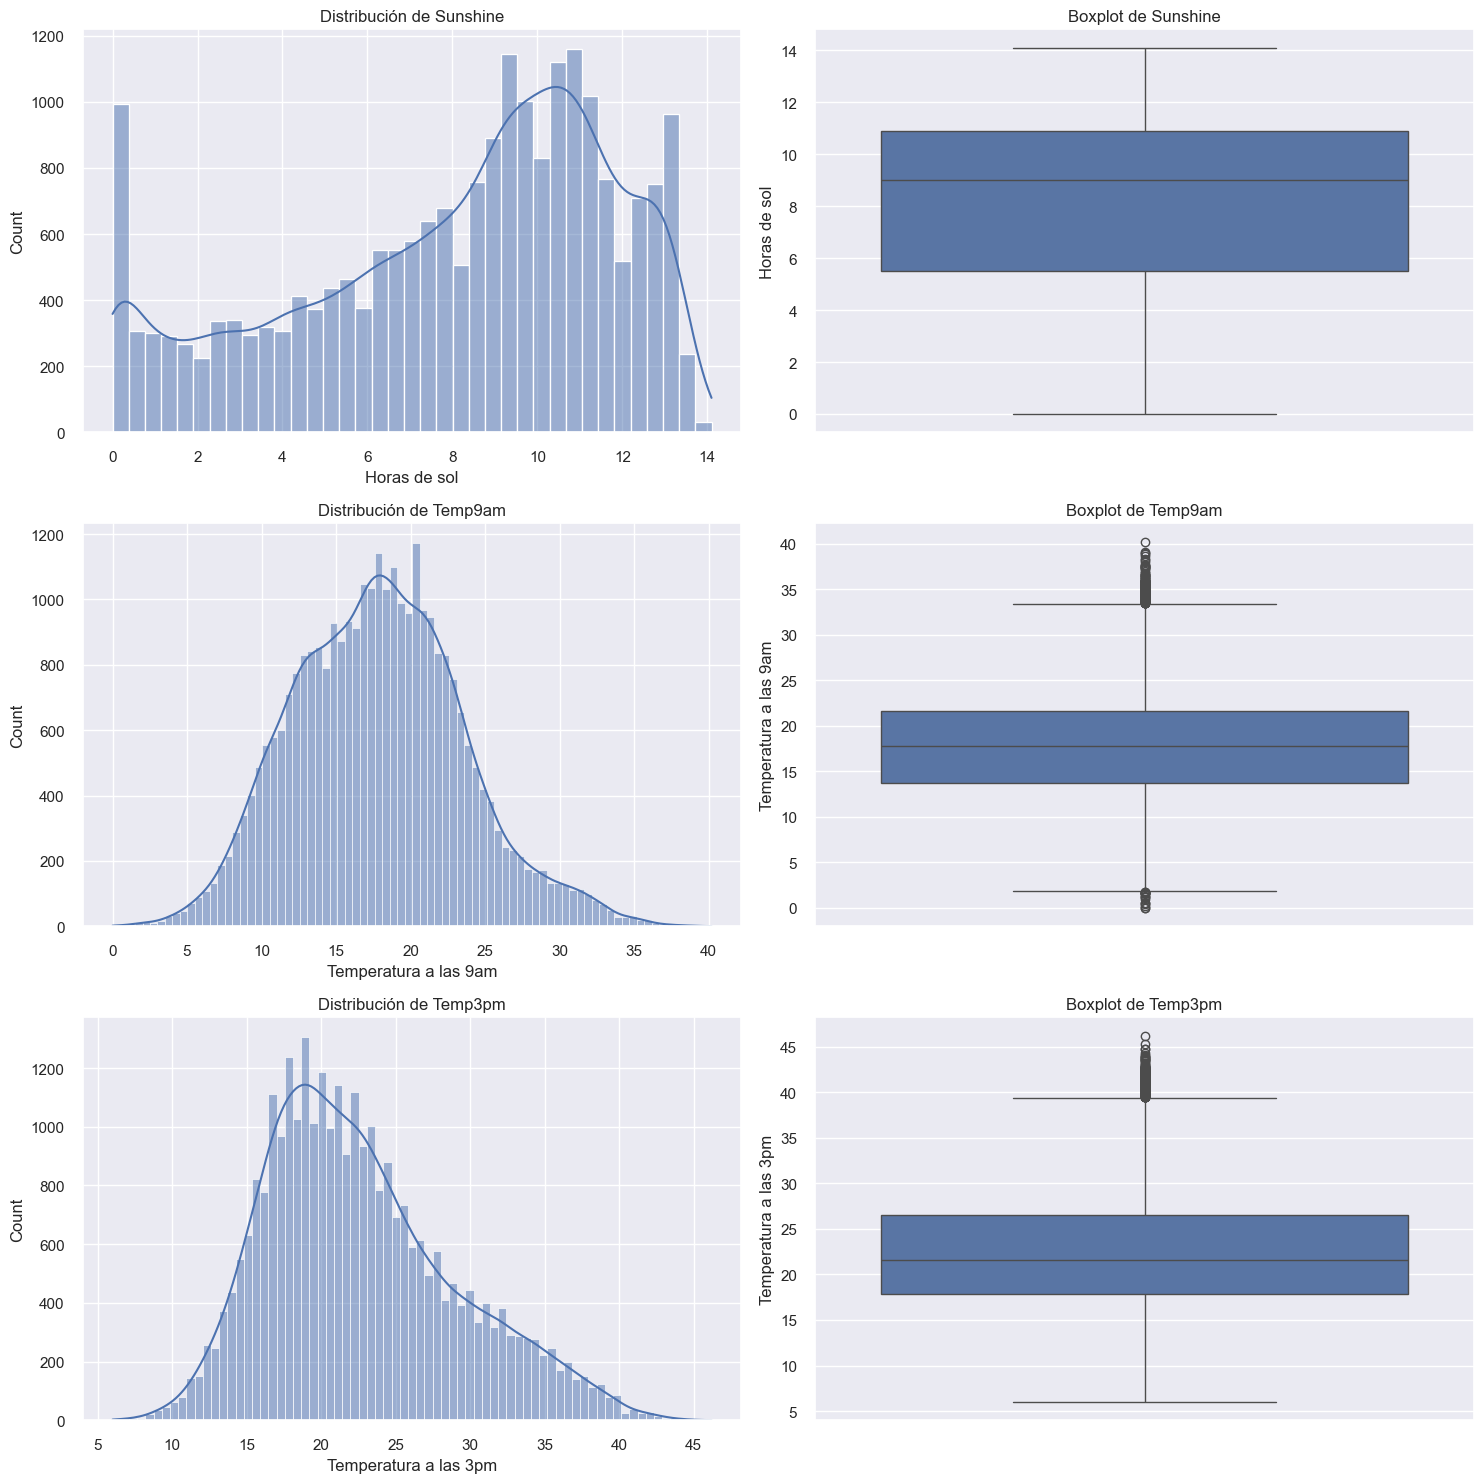

In [31]:
# Crear el gráfico para Sunshine, Temp9am y Temp3pm
plt.figure(figsize=(15, 15))

# Histograma de Sunshine
plt.subplot(3, 2, 1)
sns.histplot(weatherdata['Sunshine'], kde=True)
plt.title('Distribución de Sunshine')
plt.xlabel('Horas de sol')

# Boxplot de Sunshine
plt.subplot(3, 2, 2)
sns.boxplot(y=weatherdata['Sunshine'])
plt.title('Boxplot de Sunshine')
plt.ylabel('Horas de sol')

# Histograma de Temp9am
plt.subplot(3, 2, 3)
sns.histplot(weatherdata['Temp9am'], kde=True)
plt.title('Distribución de Temp9am')
plt.xlabel('Temperatura a las 9am')

# Boxplot de Temp9am
plt.subplot(3, 2, 4)
sns.boxplot(y=weatherdata['Temp9am'])
plt.title('Boxplot de Temp9am')
plt.ylabel('Temperatura a las 9am')

# Histograma de Temp3pm
plt.subplot(3, 2, 5)
sns.histplot(weatherdata['Temp3pm'], kde=True)
plt.title('Distribución de Temp3pm')
plt.xlabel('Temperatura a las 3pm')

# Boxplot de Temp3pm
plt.subplot(3, 2, 6)
sns.boxplot(y=weatherdata['Temp3pm'])
plt.title('Boxplot de Temp3pm')
plt.ylabel('Temperatura a las 3pm')

plt.tight_layout()
plt.show()

A pesar de la relación negativa moderada (-0.71) entre Sunshine y Cloud9am y Cloud3pm, decidimos imputar los valores nulos usando la mediana porque en el scatter no se observa una relación perfectamente lineal entre estas variables. Ademas, las distribuciones de Sunshine y las Cloud son bastante dispares.

In [32]:
# Calcular la mediana de Sunshine solo con los valores de train
mediana_Sunshine_train = X_train['Sunshine'].median()
X_train['Sunshine'] = X_train['Sunshine'].fillna(mediana_Sunshine_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Sunshine'] = X_test['Sunshine'].fillna(mediana_Sunshine_train)

# Calcular la mediana de Cloud3pm solo con los valores de train
mediana_Cloud3pm_train = X_train['Cloud3pm'].median()
X_train['Cloud3pm'] = X_train['Cloud3pm'].fillna(mediana_Cloud3pm_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Cloud3pm'] = X_test['Cloud3pm'].fillna(mediana_Cloud3pm_train)

# Calcular la mediana de Cloud9am solo con los valores de train
mediana_Cloud9am_train = X_train['Cloud9am'].median()
X_train['Cloud9am'] = X_train['Cloud9am'].fillna(mediana_Cloud9am_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Cloud9am'] = X_test['Cloud9am'].fillna(mediana_Cloud9am_train)

## Rainfall

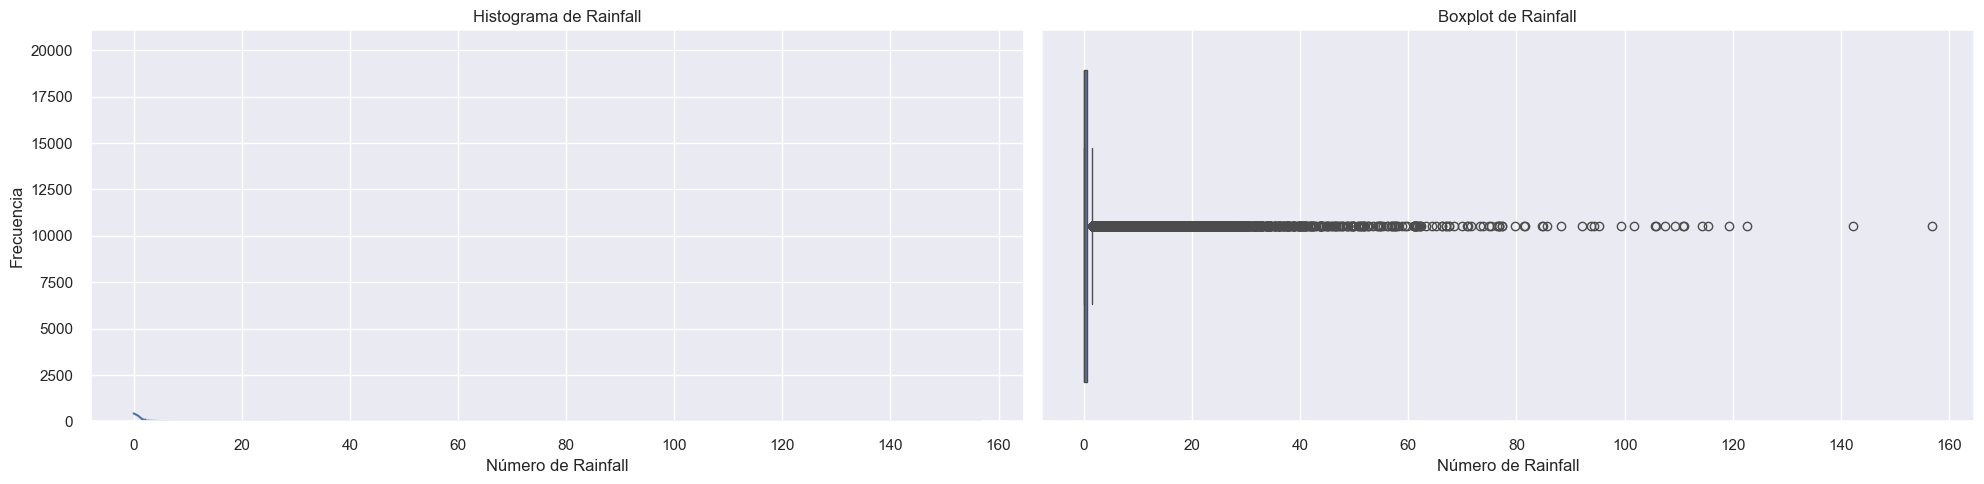

count    30134.000000
mean         1.980620
std          6.583668
min          0.000000
25%          0.000000
50%          0.000000
75%          0.600000
max        156.800000
Name: Rainfall, dtype: float64

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Número de Rainfall')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['Rainfall'].quantile(0.25)
q2 = weatherdata['Rainfall'].quantile(0.5)
q3 = weatherdata['Rainfall'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Número de Rainfall')

plt.tight_layout()
plt.show()

weatherdata['Rainfall'].describe()

La mayor parte de los valores de Rainfall se concentra en valores cercanos a 0, lo que indica que en la mayoría de los días no llueve o llueve muy poco.

Hay una gran cantidad de días con lluvias extremas (más de 20 mm), como se observa en el boxplot, donde hay valores que llegan hasta los 142.2 mm.

Dado que la mediana es 0 y la mayoría de los días tienen poco o nada de lluvia, vamos a imputar los valores nulos usando la mediana.

In [34]:
# Calcular la mediana de Rainfall solo con los valores de train
mediana_Rainfall_train = X_train['Rainfall'].median()
X_train['Rainfall'] = X_train['Rainfall'].fillna(mediana_Rainfall_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Rainfall'] = X_test['Rainfall'].fillna(mediana_Rainfall_train)

In [35]:
X_train.isna().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation      8042
Sunshine            0
WindGustDir      3692
WindGustSpeed    3691
WindDir9am       1364
WindDir3pm        284
WindSpeed9am       65
WindSpeed3pm      144
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday         363
dtype: int64

In [36]:
X_test.isna().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation      3182
Sunshine            0
WindGustDir       605
WindGustSpeed     605
WindDir9am        281
WindDir3pm        553
WindSpeed9am        4
WindSpeed3pm      542
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday         106
dtype: int64

## Evaporation

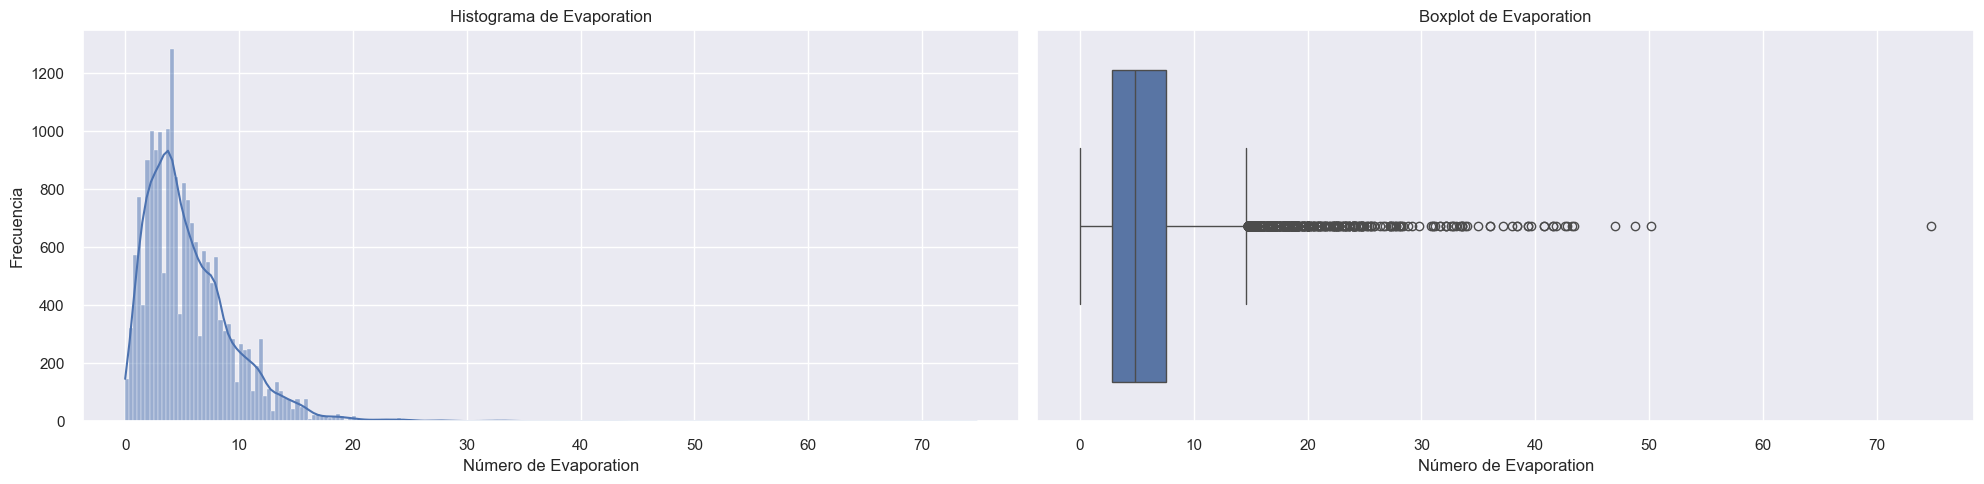

count    19379.000000
mean         5.663239
std          4.130680
min          0.000000
25%          2.800000
50%          4.800000
75%          7.600000
max         74.800000
Name: Evaporation, dtype: float64

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['Evaporation'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Número de Evaporation')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['Evaporation'].quantile(0.25)
q2 = weatherdata['Evaporation'].quantile(0.5)
q3 = weatherdata['Evaporation'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Número de Evaporation')

plt.tight_layout()
plt.show()

weatherdata['Evaporation'].describe()

La distribución de Evaporation está sesgada hacia la derecha, con la mayoría de los valores por debajo de 10 mm, aunque algunos días tienen niveles muy altos que van desde 20 mm hasta un máximo de 74.8 mm lo que podría deberse a condiciones climáticas inusuales, por lo tanto son outliers.

La mediana es de 4.8 mm, lo que indica que más del 50% de los días tienen una evaporación baja.

In [38]:
# Calcular la mediana de Evaporation solo con los valores de train
mediana_Evaporation_train = X_train['Evaporation'].median()
X_train['Evaporation'] = X_train['Evaporation'].fillna(mediana_Evaporation_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['Evaporation'] = X_test['Evaporation'].fillna(mediana_Evaporation_train)

## Wind Speed

### WindGustSpeed

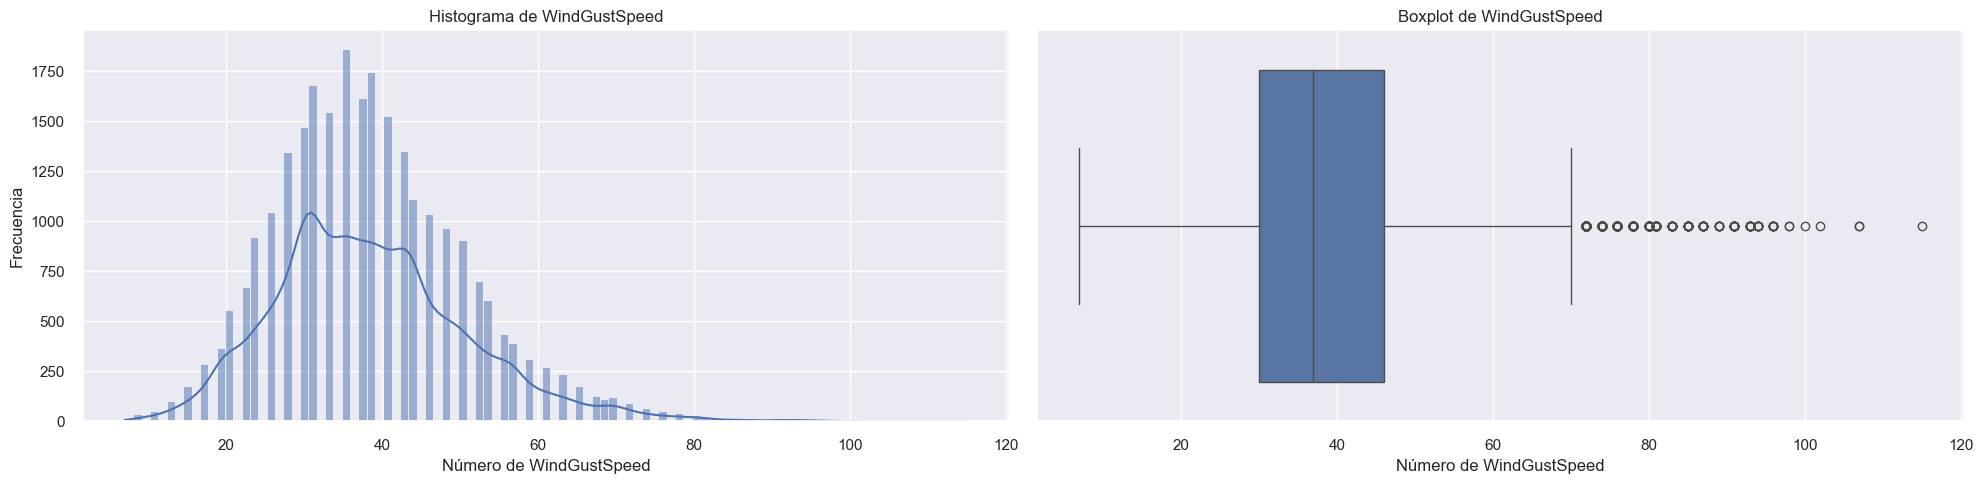

count    26307.000000
mean        38.528529
std         12.458131
min          7.000000
25%         30.000000
50%         37.000000
75%         46.000000
max        115.000000
Name: WindGustSpeed, dtype: float64

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Número de WindGustSpeed')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['WindGustSpeed'].quantile(0.25)
q2 = weatherdata['WindGustSpeed'].quantile(0.5)
q3 = weatherdata['WindGustSpeed'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Número de WindGustSpeed')

plt.tight_layout()
plt.show()

weatherdata['WindGustSpeed'].describe()

### WindSpeed9am

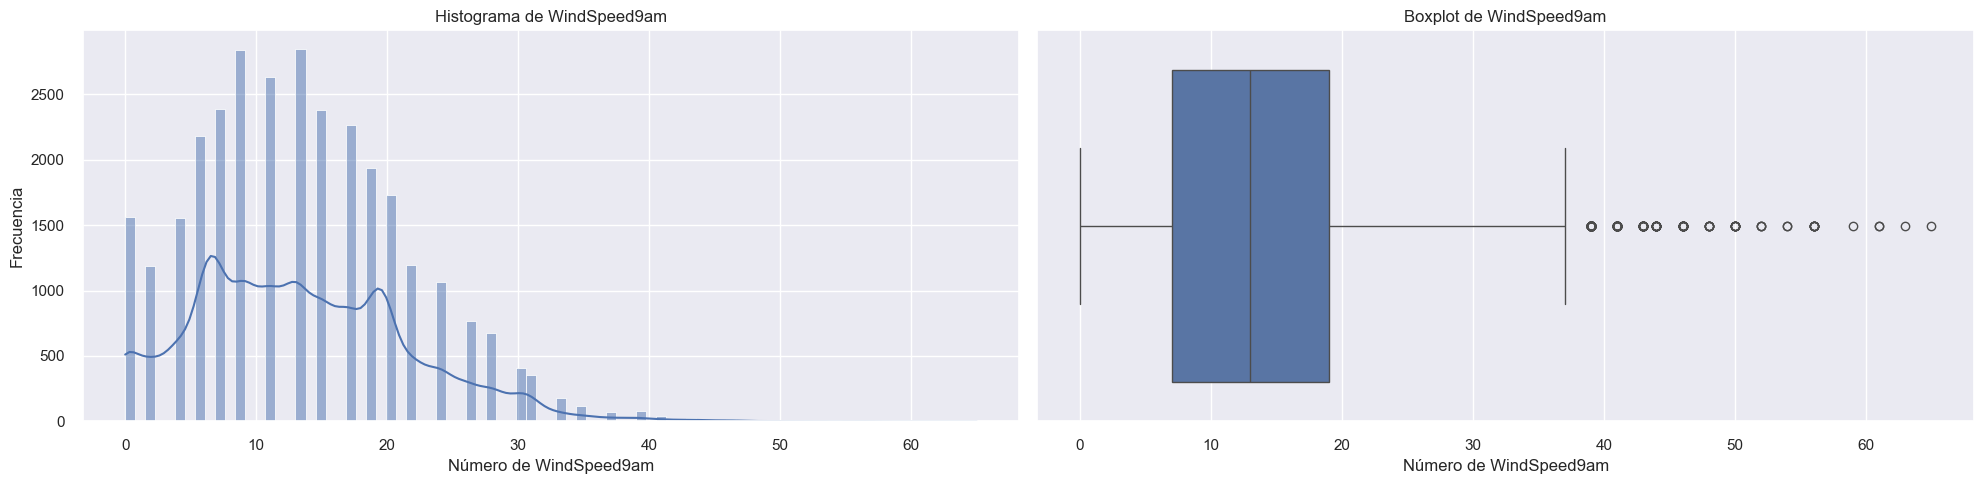

count    30534.000000
mean        13.452021
std          8.244247
min          0.000000
25%          7.000000
50%         13.000000
75%         19.000000
max         65.000000
Name: WindSpeed9am, dtype: float64

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Número de WindSpeed9am')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['WindSpeed9am'].quantile(0.25)
q2 = weatherdata['WindSpeed9am'].quantile(0.5)
q3 = weatherdata['WindSpeed9am'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Número de WindSpeed9am')

plt.tight_layout()
plt.show()

weatherdata['WindSpeed9am'].describe()

### WindSpeed3pm

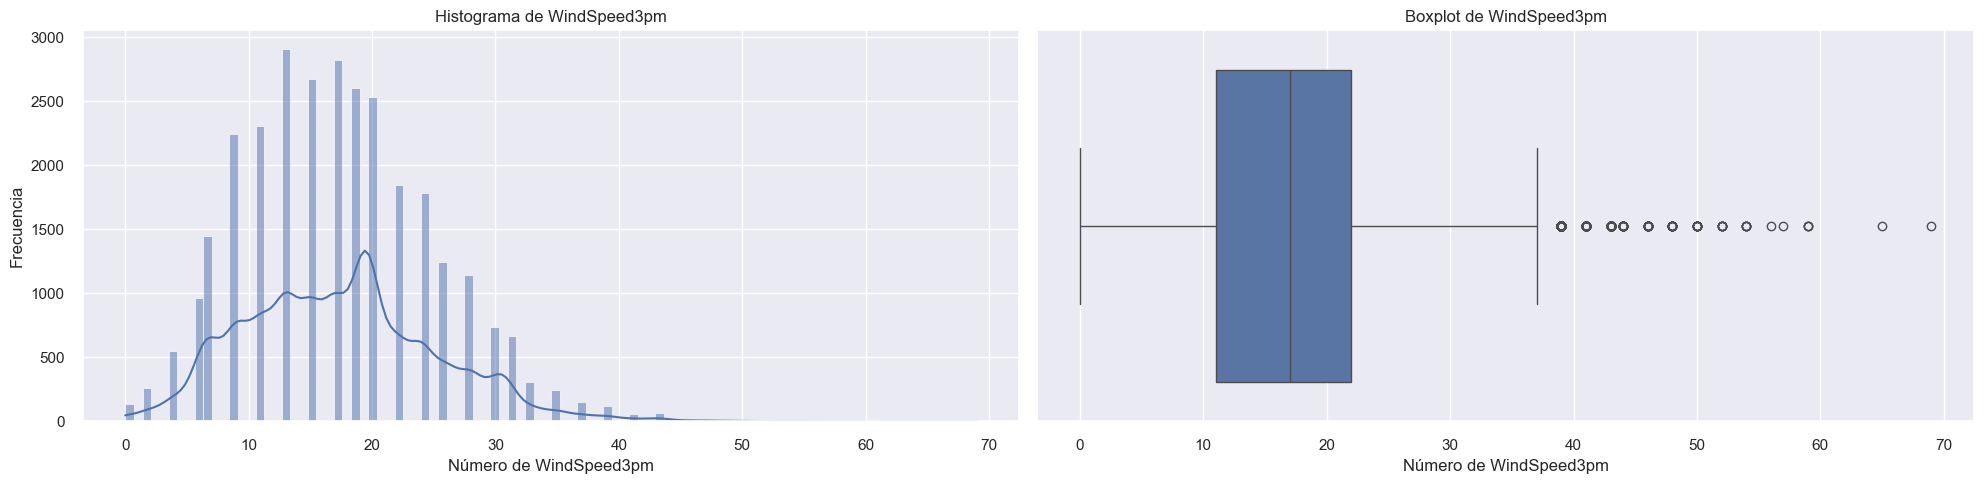

count    29917.000000
mean        17.367951
std          7.829886
min          0.000000
25%         11.000000
50%         17.000000
75%         22.000000
max         69.000000
Name: WindSpeed3pm, dtype: float64

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weatherdata['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Número de WindSpeed3pm')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles 
q1 = weatherdata['WindSpeed3pm'].quantile(0.25)
q2 = weatherdata['WindSpeed3pm'].quantile(0.5)
q3 = weatherdata['WindSpeed3pm'].quantile(0.75)

# Boxplot
sns.boxplot(x=weatherdata['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Número de WindSpeed3pm')

plt.tight_layout()
plt.show()

weatherdata['WindSpeed3pm'].describe()

### Imputacion


En general, las tres variables (WindGustSpeed, WindSpeed9am, y WindSpeed3pm) tienen distribuciones similares, la mayoría de los valores están concentrados en rangos bajos y medios, con algunos outliers que representan días con vientos mucho más fuertes. 

In [42]:
# Calcular la mediana de WindGustSpeed solo con los valores de train
mediana_WindGustSpeed_train = X_train['WindGustSpeed'].median()
X_train['WindGustSpeed'] = X_train['WindGustSpeed'].fillna(mediana_WindGustSpeed_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['WindGustSpeed'] = X_test['WindGustSpeed'].fillna(mediana_WindGustSpeed_train)

# Calcular la mediana de WindSpeed9am solo con los valores de train
mediana_WindSpeed9am_train = X_train['WindSpeed9am'].median()
X_train['WindSpeed9am'] = X_train['WindSpeed9am'].fillna(mediana_WindSpeed9am_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['WindSpeed9am'] = X_test['WindSpeed9am'].fillna(mediana_WindSpeed9am_train)

# Calcular la mediana de WindSpeed3pm solo con los valores de train
mediana_WindSpeed3pm_train = X_train['WindSpeed3pm'].median()
X_train['WindSpeed3pm'] = X_train['WindSpeed3pm'].fillna(mediana_WindSpeed3pm_train)

# Imputar en el conjunto de test usando la mediana calculada en train
X_test['WindSpeed3pm'] = X_test['WindSpeed3pm'].fillna(mediana_WindSpeed3pm_train)

## Wind Dir

### WindGustDir

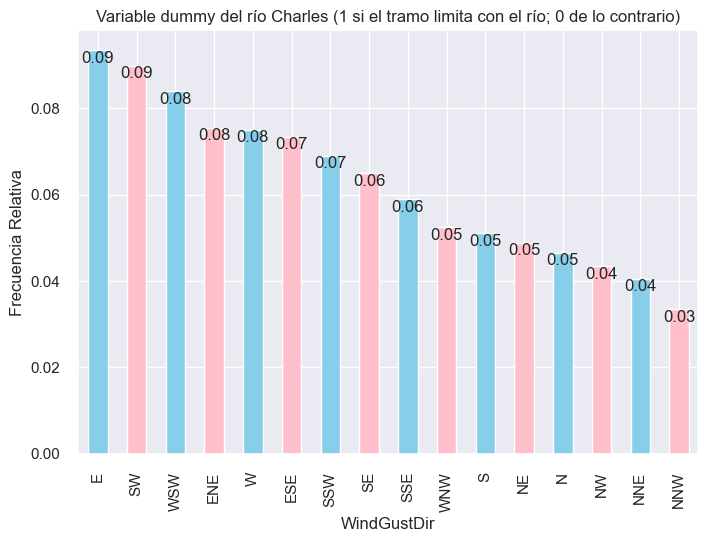

In [43]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'WindGustDir'
rel_freq = weatherdata['WindGustDir'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

### WindDir9am

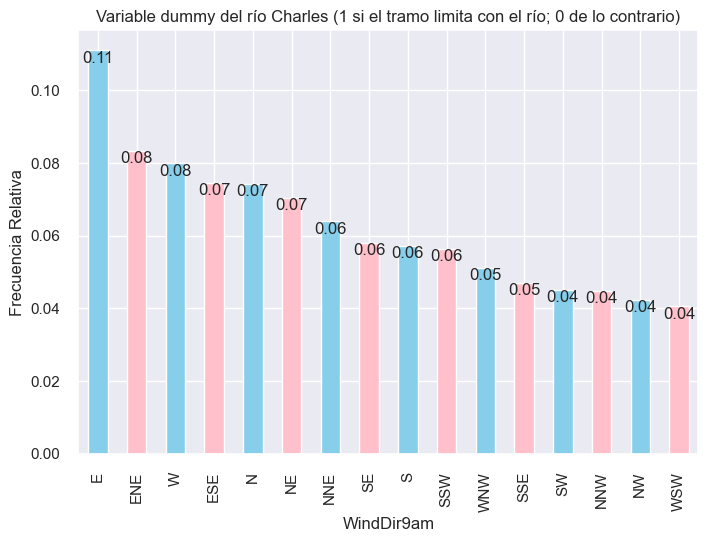

In [44]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'WindDir9am'
rel_freq = weatherdata['WindDir9am'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

### WindDir3pm

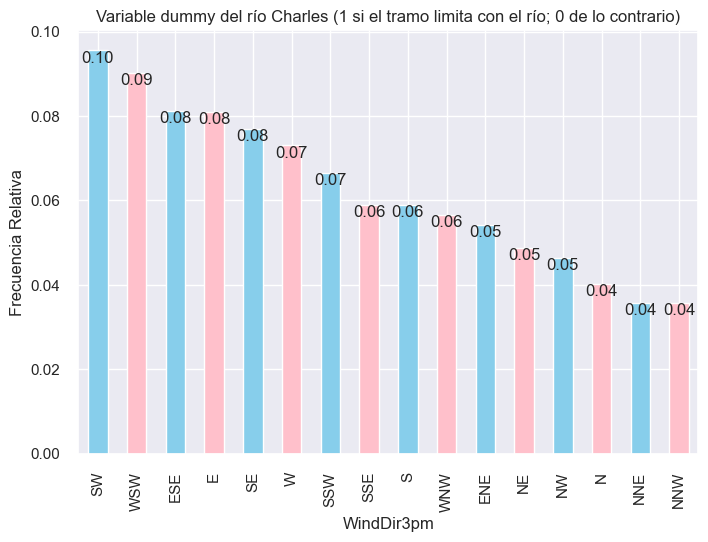

In [45]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'RainTomorrow'
rel_freq = weatherdata['WindDir3pm'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

### Imputación

In [46]:
# Calcular la moda de WindGustDir solo con los valores de train
moda_WindGustDir = X_train['WindGustDir'].mode()[0]
X_train['WindGustDir'] = X_train['WindGustDir'].fillna(moda_WindGustDir)

# Imputar en el conjunto de test usando la moda calculada en train
X_test['WindGustDir'] = X_test['WindGustDir'].fillna(moda_WindGustDir)


# Calcular la moda de WindDir9am solo con los valores de train
moda_WindDir9am = X_train['WindDir9am'].mode()[0]
X_train['WindDir9am'] = X_train['WindDir9am'].fillna(moda_WindDir9am)

# Imputar en el conjunto de test usando la moda calculada en train
X_test['WindDir9am'] = X_test['WindDir9am'].fillna(moda_WindDir9am)


# Calcular la moda de WindDir3pm solo con los valores de train
moda_WindDir3pm = X_train['WindDir3pm'].mode()[0]
X_train['WindDir3pm'] = X_train['WindDir3pm'].fillna(moda_WindDir3pm)

# Imputar en el conjunto de test usando la moda calculada en train
X_test['WindDir3pm'] = X_test['WindDir3pm'].fillna(moda_WindDir3pm)

## RainToday

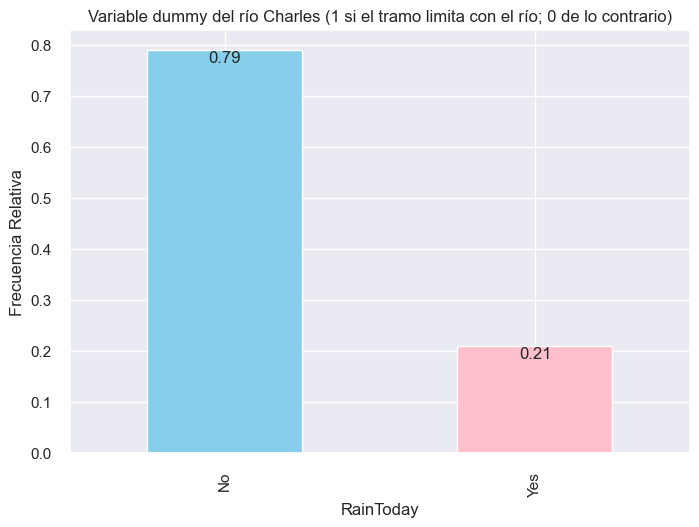

In [47]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'RainToday'
rel_freq = weatherdata['RainToday'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

In [48]:
# Calcular la moda de RainToday solo con los valores de train
moda_RainToday = X_train['RainToday'].mode()[0]
X_train['RainToday'] = X_train['RainToday'].fillna(moda_RainToday)

# Imputar en el conjunto de test usando la moda calculada en train
X_test['RainToday'] = X_test['RainToday'].fillna(moda_RainToday)

## RainTomorrow

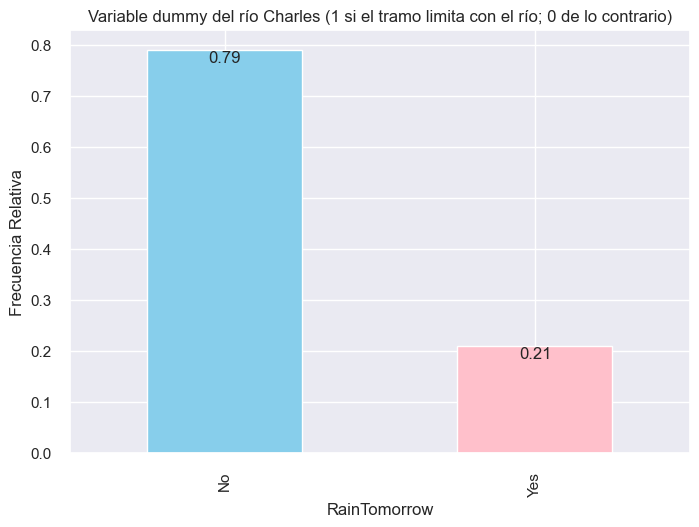

In [49]:
# GRÁFICO PARA VISUALIZAR EL BALANCE DE 'RainTomorrow'
rel_freq = weatherdata['RainTomorrow'].value_counts(normalize=True)

grafico = rel_freq.plot(kind='bar', color=['skyblue', 'pink'])

plt.title('Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)')
plt.ylabel('Frecuencia Relativa')

for index, value in enumerate(rel_freq):
    plt.text(index, value, f'{value:.2f}', ha='center', va='top')

plt.show()

In [50]:
y_train

21119      No
21120      No
21121     Yes
21122     Yes
21123      No
         ... 
138485     No
138486     No
138487     No
138488     No
138489     No
Name: RainTomorrow, Length: 24489, dtype: object

In [51]:
# Calcular la moda de RainTomorrow solo con los valores de train
moda_RainTomorrow = y_train.mode()[0]
y_train = y_train.fillna(moda_RainTomorrow)

# Imputar en el conjunto de test usando la moda calculada en train
y_test = y_test.fillna(moda_RainTomorrow)

## Conclusiones

- Date: Fecha de observación.

        Debemos eliminarla porque no contiene información relevante.
        
- Location: El nombre de la ubicación de la estación meteorológica.

        Debemos descartar todas las ubicaciones que no nos interesen y luego las restantes asumirlas como una misma y única, para poder posteriormente eliminar Location y reducir la dimensionalidad para un modelo más simple.

- MinTemp: La temperatura mínima (°C).
- MaxTemp: La temperatura máxima (°C).

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la temperatura promedio durante el día (PromTemp = MaxTemp - MinTemp)

- Rainfall: La cantidad de lluvia registrada durante el día (mm).
- Evaporation: La evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
- Sunshine: El número de horas de sol brillante en el día.
- WindGustDir: La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindGustSpeed: La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindDir9am: Dirección del viento a las 9 a.m.
- WindDir3pm: Dirección del viento a las 3 p.m.
- WindSpeed9am: Velocidad del viento (km/h) promediada de las 9 a.m.
- WindSpeed3pm: Velocidad del viento (km/h) promediada de las 3 p.m.
- Humidity9am: Humedad (porcentaje) a las 9 a.m.
- Humidity3pm: Humedad (porcentaje) a las 3 p.m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de humedad (ΔHumidity = Humidity3pm - Humidity9am)

- Pressure9am: La presión atmosférica (hPa) a las 9 a. m.
- Pressure3pm: La presión atmosférica (hPa) a las 3 p. m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de presión atmosférica (ΔPressure = Pressure3pm - Pressure9am)

- Cloud9am: Fracción del cielo oscurecida por las nubes a las 9 a.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Cloud3pm: Fracción del cielo oscurecida por las nubes a las 3 p.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Temp9am: Temperatura (grados C) a las 9 a.m.
- Temp3pm: Temperatura (grados C) a las 3 p.m.
- RainToday: Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainTomorrow: Booleano: 1 si la precipitación (mm) en las siguientes 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0

        Debemos eliminarla porque no contiene información relevante para el modelo de regresión lineal.

- RainfallTomorrow: La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".

# Dummies

Para simplificar el análisis de las direcciones del viento, agrupamos las 16 categorías distintas en 4 grupos principales: 'N' (Norte), 'S' (Sur), 'E' (Este) y 'W' (Oeste).

Las direcciones más detalladas, como 'NNW' (Noroeste-Norte) o 'ESE' (Este-Sureste), fueron mapeadas a su dirección principal correspondiente usando un diccionario. Este diccionario asocia cada dirección más granular con una de las 4 direcciones cardinales principales.

In [52]:
def agrupar_direcciones(direccion):
    grupos_principales = {
        "N": ["N", "NNW", "NNE"],
        "S": ["S", "SSW", "SSE"],
        "E": ["E", "ENE", "ESE", "SE", "NE"],
        "W": ["W", "WNW", "WSW", "SW", "NW"],
    }

    for grupo, direcciones in grupos_principales.items():
        if direccion in direcciones:
            return grupo

    return "Otro"

Para codificar las variables referentes a la direccion del viento (WindGustDir, WindDir9am y WindDir3pm) usamos una **Codificación Trigonométrica** porque nos permite representar las direcciones en términos numéricos, capturando su naturaleza circular.

In [53]:
# Mapeo de direcciones a ángulos
direccion_a_grados = {'N': 0, 'E': 90, 'S': 180, 'W': 270}

# Aplicar agrupamiento de direcciones en X_train y X_test
X_train['WindGustDir'] = X_train['WindGustDir'].apply(agrupar_direcciones)
X_train['WindDir9am'] = X_train['WindDir9am'].apply(agrupar_direcciones)
X_train['WindDir3pm'] = X_train['WindDir3pm'].apply(agrupar_direcciones)

X_test['WindGustDir'] = X_test['WindGustDir'].apply(agrupar_direcciones)
X_test['WindDir9am'] = X_test['WindDir9am'].apply(agrupar_direcciones)
X_test['WindDir3pm'] = X_test['WindDir3pm'].apply(agrupar_direcciones)

# Ahora aplicamos las funciones trigonométricas (sin y cos) directamente sobre las columnas originales

# Para X_train
X_train['WindGustDir_sin'] = np.sin(np.deg2rad(X_train['WindGustDir'].map(direccion_a_grados)))
X_train['WindGustDir_cos'] = np.cos(np.deg2rad(X_train['WindGustDir'].map(direccion_a_grados)))

X_train['WindDir9am_sin'] = np.sin(np.deg2rad(X_train['WindDir9am'].map(direccion_a_grados)))
X_train['WindDir9am_cos'] = np.cos(np.deg2rad(X_train['WindDir9am'].map(direccion_a_grados)))

X_train['WindDir3pm_sin'] = np.sin(np.deg2rad(X_train['WindDir3pm'].map(direccion_a_grados)))
X_train['WindDir3pm_cos'] = np.cos(np.deg2rad(X_train['WindDir3pm'].map(direccion_a_grados)))

# Para X_test
X_test['WindGustDir_sin'] = np.sin(np.deg2rad(X_test['WindGustDir'].map(direccion_a_grados)))
X_test['WindGustDir_cos'] = np.cos(np.deg2rad(X_test['WindGustDir'].map(direccion_a_grados)))

X_test['WindDir9am_sin'] = np.sin(np.deg2rad(X_test['WindDir9am'].map(direccion_a_grados)))
X_test['WindDir9am_cos'] = np.cos(np.deg2rad(X_test['WindDir9am'].map(direccion_a_grados)))

X_test['WindDir3pm_sin'] = np.sin(np.deg2rad(X_test['WindDir3pm'].map(direccion_a_grados)))
X_test['WindDir3pm_cos'] = np.cos(np.deg2rad(X_test['WindDir3pm'].map(direccion_a_grados)))

# Elimina las columnas originales si ya no son necesarias
X_train.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)
X_test.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)


Vamos a usar **One-Hot Encoding** para convertir las variables 'Yes' y 'No' en 1 y 0.

In [54]:
# Mapeo de 'Si' y 'No' a 1 y 0 en las columnas que lo necesiten en X_train y X_test
X_train['RainToday'] = X_train['RainToday'].map({'Yes': 1, 'No': 0})
X_test['RainToday'] = X_test['RainToday'].map({'Yes': 1, 'No': 0})

y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

# Estandarización

In [55]:
scaler = StandardScaler()

 Estandarización de X_train y X_test

In [56]:
# Seleccionar las columnas a estandarizar
columnas_a_estandarizar = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'WindGustDir_sin', 'WindGustDir_cos',
       'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos']

# Ajustar y transformar X_train
X_train[columnas_a_estandarizar] = scaler.fit_transform(X_train[columnas_a_estandarizar])

# Transformar X_test usando el mismo escalador ajustado con X_train
X_test[columnas_a_estandarizar] = scaler.transform(X_test[columnas_a_estandarizar])

# Regresión Logística

Nuestro objetivo principal es predecir correctamente **cuándo va a llover**, es decir, **maximizar los verdaderos positivos.** Esto es crucial porque, al anticipar con precisión la lluvia, las personas pueden tomar medidas preventivas, como llevar paraguas, cambiar planes, proteger sus bienes, etc.

Al mismo tiempo, también buscamos predecir de manera precisa los días en que no va a llover (verdaderos negativos) Sin embargo, el impacto de equivocarse aquí es menor comparado con fallar en la predicción de lluvia.

En resumen, queremos enfocarnos en **maximizar los verdaderos positivos** para asegurar que nadie sea sorprendido por la lluvia, sin descuidar la importancia de predecir correctamente los días sin lluvia.

#### Modelo base

In [57]:
# Supongamos que seleccionamos la primera columna de X_train y X_test como base
X_train_base = X_train.iloc[:, [0]]  # Seleccionamos la primera columna de X_train
X_test_base = X_test.iloc[:, [0]]    # Seleccionamos la primera columna de X_test

# y_train e y_test siguen siendo los mismos (etiquetas)
y_train_base = y_train.copy()  # Hacemos una copia de y_train
y_test_base = y_test.copy()    # Hacemos una copia de y_test


In [58]:
modelo_base = LogisticRegression(random_state=42)
modelo_base.fit(X_train_base, y_train_base)

LogisticRegression(random_state=42)

#### Modelo

In [59]:
modelo_rl = LogisticRegression(random_state=42)
modelo_rl.fit(X_train, y_train)

LogisticRegression(random_state=42)

#### Modelo balanceado con `class_weight`

In [60]:
# Modelo con balanceo de clases
modelo_rl_balanced = LogisticRegression(class_weight='balanced', random_state=42)
modelo_rl_balanced.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

#### Modelo balanceado con `SMOTET`

In [61]:
# Aplicar SMOTETomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)

if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

In [62]:
print("Distribución original:")
print(y_train.value_counts(normalize=True))

print("\nDistribución después del balanceo:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

Distribución original:
RainTomorrow
0    0.793907
1    0.206093
Name: proportion, dtype: float64

Distribución después del balanceo:
RainTomorrow
0    0.5
1    0.5
Name: proportion, dtype: float64


In [63]:
# Modelo con balanceo de clases
modelo_rl_smotet = LogisticRegression(random_state=42)
modelo_rl_smotet.fit(X_train_balanced, y_train_balanced)

LogisticRegression(random_state=42)

#### Función para evaluar modelos

In [64]:
def evaluar_modelo(modelo, X_test, y_test, title=''):
    """
    Función para evaluar un modelo de clasificación.
    
    Argumentos:
    modelo -- El modelo entrenado.
    X_test -- Conjunto de características de prueba.
    y_test -- Conjunto de etiquetas de prueba.
    title -- Título opcional para el reporte del modelo.
    """
    # Hacer predicciones
    y_pred = modelo.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Imprimir las métricas
    print(f'--------------------------------')
    print(f'Modelo {title}:')
    print(f'--------------------------------')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Imprimir reporte de clasificación
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    
    # Crear el gráfico de la matriz de confusión
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'])
    
    # Añadir etiquetas a los ejes
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión {title}')
    plt.show()

#### Evaluacion de modelos

--------------------------------
Modelo base:
--------------------------------
Accuracy: 0.7900
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4830
           1       0.00      0.00      0.00      1284

    accuracy                           0.79      6114
   macro avg       0.39      0.50      0.44      6114
weighted avg       0.62      0.79      0.70      6114

[[4830    0]
 [1284    0]]


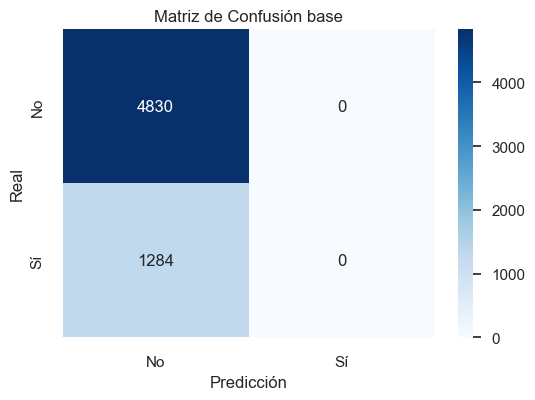

--------------------------------
Modelo sin balanceo de clases:
--------------------------------
Accuracy: 0.8477
Precision: 0.7833
Recall: 0.3801
F1 Score: 0.5118
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4830
           1       0.78      0.38      0.51      1284

    accuracy                           0.85      6114
   macro avg       0.82      0.68      0.71      6114
weighted avg       0.84      0.85      0.83      6114

[[4695  135]
 [ 796  488]]


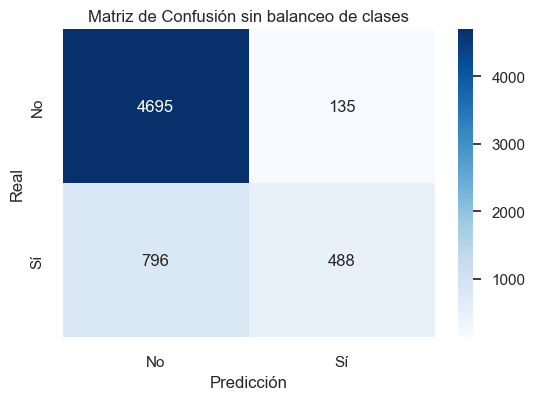

--------------------------------
Modelo con balanceo de clases:
--------------------------------
Accuracy: 0.8204
Precision: 0.5609
Recall: 0.6667
F1 Score: 0.6093
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4830
           1       0.56      0.67      0.61      1284

    accuracy                           0.82      6114
   macro avg       0.73      0.76      0.75      6114
weighted avg       0.83      0.82      0.83      6114

[[4160  670]
 [ 428  856]]


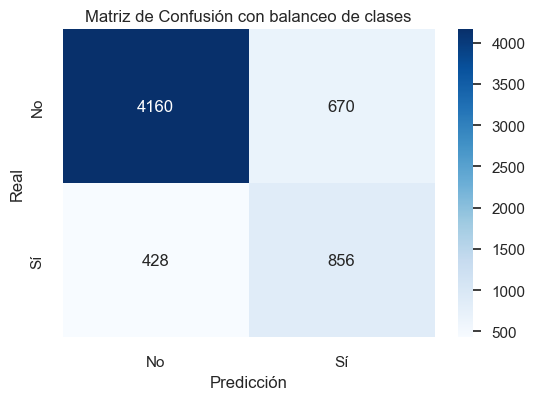

--------------------------------
Modelo con balanceo de clases SMOTET:
--------------------------------
Accuracy: 0.8167
Precision: 0.5530
Recall: 0.6628
F1 Score: 0.6029
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4830
           1       0.55      0.66      0.60      1284

    accuracy                           0.82      6114
   macro avg       0.73      0.76      0.74      6114
weighted avg       0.83      0.82      0.82      6114

[[4142  688]
 [ 433  851]]


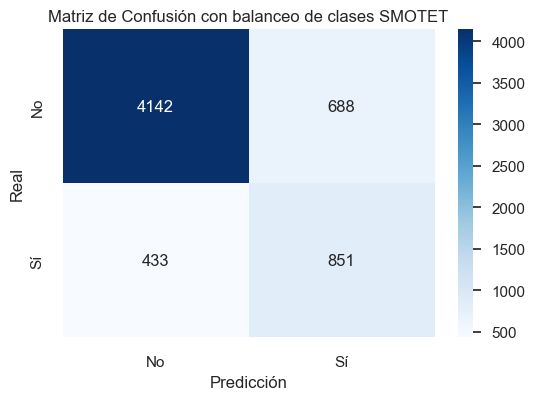

In [65]:
# Uso de la función para los dos modelos
evaluar_modelo(modelo_base, X_test_base, y_test_base, title='base')
evaluar_modelo(modelo_rl, X_test, y_test, title='sin balanceo de clases')
evaluar_modelo(modelo_rl_balanced, X_test, y_test, title='con balanceo de clases')
evaluar_modelo(modelo_rl_smotet, X_test, y_test, title='con balanceo de clases SMOTET')

**Evaluación del f1-score en modelos desbalanceados**

Para el análisis, nos enfocaremos en el f1-score de la clase minorista, **SI LLOVERÁ (1)**, ya que es el más adecuado al tratar modelos con clases desbalanceadas, ofreciendo una métrica más confiable y equilibrada. Cabe destacar que el modelo base resulta muy deficiente, ya que únicamente predice la clase mayoritaria **NO LLOVERÁ (0)** y por esto lo descartamos automaticamente.

Las métricas obtenidas para cada modelo son las siguientes:

- **Modelo sin balanceo**: f1-score de 0.51
- **Modelo balanceado**: f1-score de 0.61
- **Modelo balanceado con SMOTET**: f1-score de 0.60

**Conclusión**: Optamos por el modelo balanceado. Aunque su desempeño es cercano al del modelo balanceado con SMOTET, éste último presenta ciertas limitaciones. SMOTET equilibra los datos mediante la creación de nuevas instancias en la clase minoritaria y la eliminación en la clase mayoritaria, lo cual puede introducir sesgos debido a la generación y eliminación artificial de datos. En cambio, el balanceo atravez de `class_weight='balanced'` mantiene la integridad del conjunto original sin estas modificaciones adicionales ya que La clase minoritaria recibe un mayor peso en la función de costo del modelo, incentivando al modelo a penalizar más los errores en dicha clase y resultando en un modelo potencialmente más robusto y representativo.

## Curva ROC

El mejor umbral basado en la curva ROC es: 0.4284
Precision con umbral óptimo: 0.5079
Recall con umbral óptimo: 0.7274
F1 Score con umbral óptimo: 0.5981


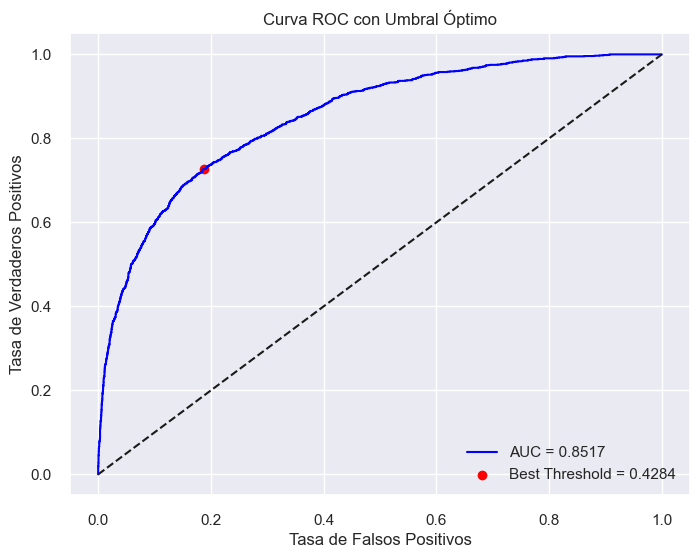

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, roc_auc_score

# Probabilidad de la clase positiva (lluvia)
y_probs = modelo_rl_balanced.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular el AUC
auc = roc_auc_score(y_test, y_probs)

# Calcular el mejor umbral (máximo balance entre TP y FP)
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"El mejor umbral basado en la curva ROC es: {best_threshold:.4f}")

# Generar predicciones ajustando al mejor umbral
y_pred_umbral = (y_probs >= best_threshold).astype(int)

# Calcular métricas para el umbral óptimo
precision = precision_score(y_test, y_pred_umbral)
recall = recall_score(y_test, y_pred_umbral)
f1 = f1_score(y_test, y_pred_umbral)

# Imprimir resultados
print(f'Precision con umbral óptimo: {precision:.4f}')
print(f'Recall con umbral óptimo: {recall:.4f}')
print(f'F1 Score con umbral óptimo: {f1:.4f}')

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal de referencia

# Marcar el punto del mejor umbral
best_idx = np.argmax(tpr - fpr)
plt.scatter(fpr[best_idx], tpr[best_idx], marker='o', color='red', label=f'Best Threshold = {best_threshold:.4f}')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC con Umbral Óptimo')
plt.legend(loc='lower right')
plt.show()


La curva ROC de nuestro modelo se representa en la línea azul del gráfico. La línea diagonal punteada, por otro lado, indica el rendimiento de un modelo aleatorio con un AUC de 0.5. Si nuestro modelo se posicionara en esa línea, implicaría que su desempeño es equiparable al de un modelo aleatorio. En el caso de encontrarse por debajo de dicha línea, significaría que un modelo aleatorio resultaría superior a nuestro modelo.

El Área Bajo la Curva (AUC) para nuestro modelo es de 0.8517, lo cual es un indicador muy bueno. Recordemos que un AUC de 1 representa un modelo perfecto (con una curva que pasa por el punto superior izquierdo, (0,1), en el gráfico). Con nuestro valor de AUC, estamos logrando una aproximación significativa hacia ese ideal.

Para asignar clases, nuestro modelo calcula la probabilidad de pertenencia usando un umbral, el cual puede ser ajustado manualmente según sea necesario. En nuestro caso, el umbral óptimo se ha determinado en 0.4284. Esto significa que, si la probabilidad calculada es mayor que este valor, el dato se clasifica como clase 1; de lo contrario, se clasifica como clase 0.

# Optimizacion de hiperparámetros

## Validación Cruzada k-folds

Dependencia Temporal: Dado que la predicción es de una variable dependiente del tiempo (lluvia en función del clima del día anterior), k-fold puede no ser ideal ya que no respeta el orden temporal de los datos. Las particiones en k-fold dividen los datos de manera aleatoria, lo que podría resultar en conjuntos de entrenamiento y prueba que no respeten la secuencia temporal, generando una fuga de datos.

## Grid search

Elegimos estos hiperparámetros porque son los que más impacto tienen en el desempeño de un modelo de regresión logística. Controlan la regularización, la optimización y el manejo de datos desbalanceados, permitiéndonos ajustar el modelo para que sea preciso y robusto sin desperdiciar tiempo o recursos en opciones menos relevantes.

- **`C`**: Ajusta cuánto regularizamos. Si es muy alto, el modelo sobreajusta; si es muy bajo, no aprende lo suficiente.

- **`solver`**: Define el algoritmo de optimización. Elegimos según el tipo de penalización (`l1` o `l2`) y el tamaño de los datos.

- **`penalty`**: Decide el tipo de regularización. `l1` elimina variables irrelevantes, `l2` reduce la magnitud de los coeficientes.

- **`max_iter`**: Asegura que el modelo tenga tiempo para converger. Demasiado bajo impide un buen ajuste, demasiado alto es ineficiente.

- **`class_weight`**: Maneja el desbalance de clases. `balanced` ajusta los pesos automáticamente para evitar favorecer la mayoría.

In [67]:
# Definición de los métodos de optimización y medición del tiempo
results = []
results_balanced = []

start_time = time.time()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Rango ampliado para la regularización
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Añadimos 'saga' compatible con l2
    'penalty': ['l2', 'l1'],  # Mantener las opciones principales
    'max_iter': [100, 200, 300],  # Añadimos una opción adicional
    'class_weight': [None, 'balanced']  # Mantener
}


# Configuración del GridSearch
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000, class_weight='balanced', random_state=45),
    param_grid=param_grid,
    scoring='f1',
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
grid_search_time = time.time() - start_time
grid_search_f1 = f1_score(y_test, grid_search.predict(X_test), pos_label=1)
results.append({
    "Method": "Grid Search",
    "Best Params": grid_search.best_params_,
    "Time (s)": grid_search_time,
    "F1 Score": grid_search_f1
})


grid_search_balanced = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000, class_weight='balanced', random_state=45),
    param_grid=param_grid,
    scoring='f1',
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1
)
grid_search_balanced.fit(X_train_balanced, y_train_balanced)
grid_search_time_balanced = time.time() - start_time
grid_search_f1_balanced = f1_score(y_test, grid_search_balanced.predict(X_test), pos_label=1)
results.append({
    "Method": "Grid Search Balanced data",
    "Best Params": grid_search_balanced.best_params_,
    "Time (s)": grid_search_time_balanced,
    "F1 Score": grid_search_f1_balanced
})

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


## Random search

In [68]:
start_time = time.time()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Rango ampliado para la regularización
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Añadimos 'saga' compatible con l2
    'penalty': ['l2', 'l1'],  # Mantener las opciones principales
    'max_iter': [100, 200, 300],  # Añadimos una opción adicional
    'class_weight': [None, 'balanced']  # Mantener
}

random_search = RandomizedSearchCV(LogisticRegression(max_iter=2000, class_weight='balanced', random_state=45), param_grid, scoring='f1', cv=5, n_iter=20, random_state=42)
random_search.fit(X_train_balanced, y_train_balanced)
random_search_time = time.time() - start_time
random_search_f1 = f1_score(y_test, random_search.predict(X_test), pos_label=1)

results.append({
    "Method": "Random Search",
    "Best Params": random_search.best_params_,
    "Time (s)": random_search_time,
    "F1 Score": random_search_f1
})

## Optuna

In [ ]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    # Seleccionar solver compatible con el penalty
    if penalty == 'l1':
        solver = 'liblinear'
    else:
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=2000, class_weight='balanced', random_state=45)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, pos_label=1)

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
optuna_time = time.time() - start_time
optuna_f1 = f1_score(y_test, LogisticRegression(**study.best_params, max_iter=2000).fit(X_train_balanced, y_train_balanced).predict(X_test), pos_label=1)

results.append({
    "Method": "Optuna",
    "Best Params": study.best_params,
    "Time (s)": optuna_time,
    "F1 Score": optuna_f1
})

## Comparación 

In [72]:
# Convertir los resultados a DataFrame para mostrar en tabla Markdown
results_df = pd.DataFrame(results)

print(tabulate(results_df, headers='keys', tablefmt='pipe', showindex=False, numalign='center', colalign=("center",)))

|          Method           | Best Params                                                                                      |  Time (s)  |  F1 Score  |
|:-------------------------:|:-------------------------------------------------------------------------------------------------|:----------:|:----------:|
|        Grid Search        | {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}      |  51.9651   |  0.608079  |
| Grid Search Balanced data | {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'} |  115.327   |  0.600565  |
|       Random Search       | {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'class_weight': None, 'C': 0.01}       |  19.0202   |  0.600565  |


Los resultados muestran que todos los métodos alcanzaron un F1-Score bastante similar, en el rango de 0.600 a 0.608, lo que indica que el modelo tiene un desempeño consistente independientemente del método de optimización. Sin embargo, el mejor F1-Score fue obtenido con Grid Search (F1 = 0.608079), utilizando los parámetros {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}. Esto lo convierte en la elección más lógica si buscamos maximizar la métrica de desempeño.

Aunque Optuna es claramente el más rápido, el tiempo de ejecución no es tan relevante en este caso porque los métodos tardaron relativamente poco en completarse.

# SHAP

In [88]:
feature_names = X_train.columns.values
# feature_names

In [89]:
# CREAR OBJETO EXPLAINER
log_explainer = shap.LinearExplainer(modelo_rl, X_train, feature_names=feature_names)

# CALCULAR VALORES SHAP PARA EL CONJUNTO DE TEST
log_shap_values = log_explainer.shap_values(X_test)

## SHAP LOCAL

In [90]:
# EXPLICACIÓN SHAP A NIVEL LOCAL
log_local_explanation = shap.Explanation(values=log_shap_values[50],
                                     base_values=log_explainer.expected_value,
                                     feature_names=feature_names)

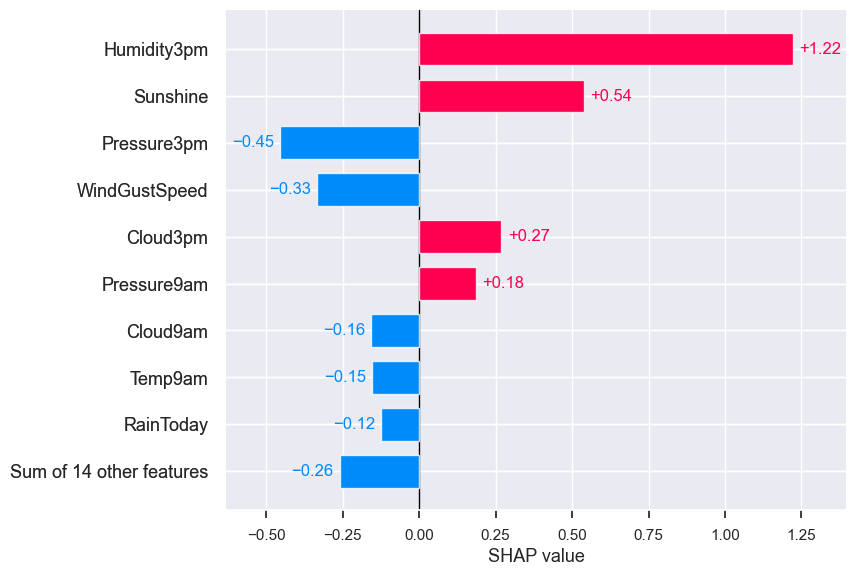

In [91]:
shap.plots.bar(log_local_explanation)

En este grafico podemos ver cómo cada característica influye positiva o negativamente en la predicción para una instancia específica.

* Humidity3pm (+1.22) y Sunshine (+0.54) tienen los mayores impactos positivos, aumentando la predicción.
* Pressure3pm (-0.45) y WindGustSpeed (-0.33) son las principales características que reducen la predicción.
* Las demás variables tienen impactos menores, con una contribución acumulada de -0.26.

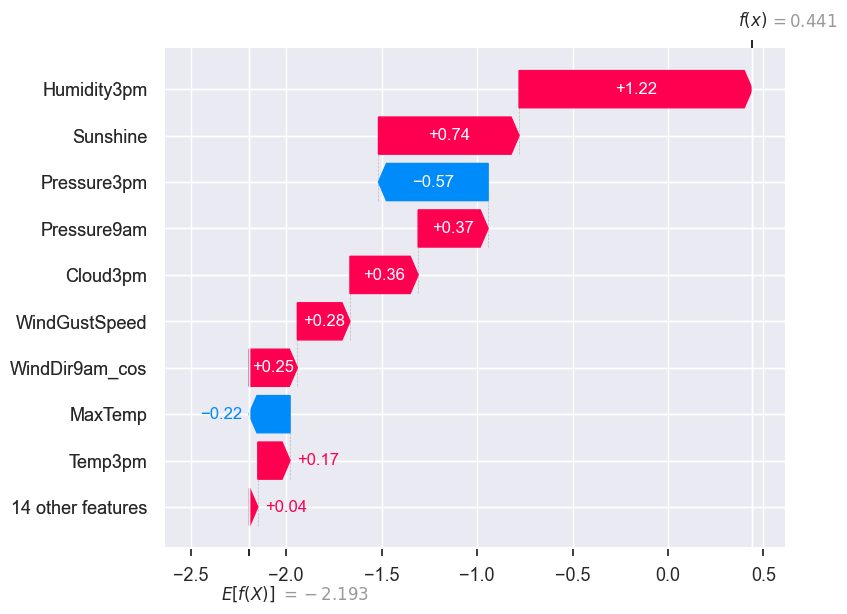

In [92]:
log_local_explanation = shap.Explanation(values=log_shap_values[3983],
                                     base_values=log_explainer.expected_value,
                                     feature_names=feature_names)

shap.plots.waterfall(log_local_explanation)

Este gráfico desglosa cómo las características individuales ajustaron la predicción del modelo para una instancia específica

Características con mayor impacto positivo:

* Humidity3pm (+1.22): Principal contribuyente al aumento de la predicción.
* Sunshine (+0.74): Segundo mayor impacto positivo.
* Cloud3pm, Pressure9am, y WindGustSpeed también contribuyen al incremento, aunque con menor magnitud.

Características con mayor impacto negativo:
* Pressure3pm (-0.57): Principal factor que reduce la predicción.
* MaxTemp (-0.22): También disminuye la predicción, aunque en menor medida.

Otras características:

* WindDir9am_cos (+0.25) y Temp3pm (+0.17) tienen pequeños efectos positivos.
Las 14 características restantes tienen un impacto acumulado muy bajo (+0.04).

## SHAP GLOBAL

In [93]:
# EXPLICACIÓN SHAP A NIVEL GLOBAL
log_global_explanation = shap.Explanation(values=log_shap_values,
                                      base_values=log_explainer.expected_value,
                                      feature_names=feature_names,
                                      data=X_test)

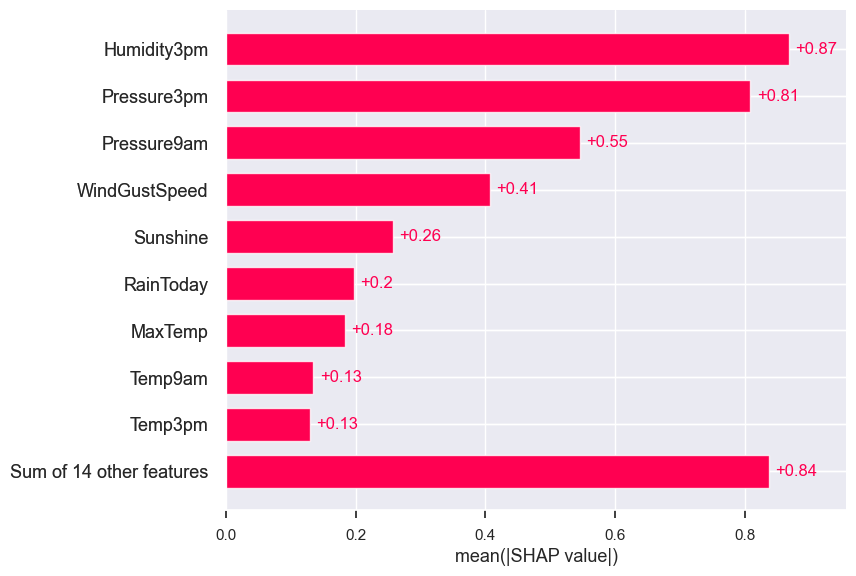

In [94]:
shap.plots.bar(log_global_explanation)

Este gráfico muestra el impacto promedio absoluto de cada característica en todas las predicciones del modelo, lo que permite identificar las variables más importantes a nivel global.

**Características más influyentes:**

* Humidity3pm (+0.87): Es la característica más importante globalmente, con el mayor impacto promedio en las predicciones.
* Pressure3pm (+0.81) y Pressure9am (+0.55) también destacan como variables clave en el modelo.
* WindGustSpeed (+0.41): Tiene una contribución relevante en las predicciones.

**Características de menor influencia:**

Variables como Temp9am, Temp3pm, y MaxTemp tienen impactos globales más bajos, aunque siguen siendo relevantes en comparación con el resto.

**Impacto acumulado de otras características:**

El grupo de las 14 características restantes tiene un impacto combinado de +0.84, lo que resalta que la mayoría de las predicciones están dominadas por unas pocas características clave.

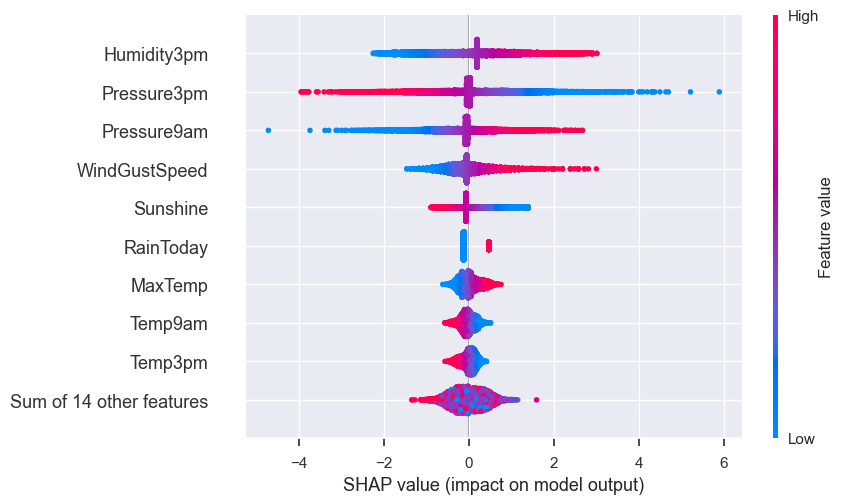

In [95]:
shap.plots.beeswarm(log_global_explanation)

Este gráfico combina información global y local para cada característica. Presenta la dispersión de los valores SHAP de todas las instancias del dataset.

* **Humidity3pm:** Tiene los valores SHAP más amplios, tanto positivos como negativos, lo que confirma su alta influencia en el modelo. Valores altos (en rojo) tienden a aumentar las predicciones, mientras que valores bajos (en azul) las reducen.

* **Pressure3pm y Pressure9am:** Ambas tienen un comportamiento similar. Los valores bajos (azul) reducen significativamente la predicción, mientras que los valores altos (rojo) aumentan las predicciones.

* **WindGustSpeed y Sunshine:** Muestran menos dispersión en comparación con las presiones y la humedad.
Los valores altos (rojo) de estas variables tienden a incrementar la predicción.

* **Otras características (Temp9am, Temp3pm, etc.):** Tienen menor dispersión y por lo tanto menor influencia global. Sus valores altos y bajos afectan poco la predicción.


* **Contribución acumulada de las otras características:** El impacto combinado del resto de características también puede ser significativo, aunque menos prominente.

## Conclusion

A nivel global, las variables más importantes son la humedad a las 3 PM (Humidity3pm) y las presiones atmosféricas (Pressure3pm y Pressure9am), ya que tienen el mayor impacto en las predicciones. Esto se ve también a nivel local, donde las mismas variables aparecen constantemente como los mayores impulsores, tanto positivos como negativos.

Características como la velocidad del viento (WindGustSpeed) y la luz solar (Sunshine) también son relevantes, pero con menos fuerza comparadas con las principales.

Variables como las temperaturas (Temp9am, Temp3pm) tienen un impacto más pequeño, lo que indica que no son tan decisivas en el modelo.

# Auto ML


Cargamos nuevamente el dataset original para aplicar el minimo de preprocesamiento posible, cumpliendo con el requerimiento de **Pycaret** de que no haya valores nulos en la variable target, en este caso "Raintomorrow".

Tambien, al cargar nuevamente el dataset completo, volvemos a quedarnos con los datos de las respectivas ciudades que seleccionamos aleatoriamente al inicio.

In [ ]:
data_automl = pd.read_csv('weatherAUS.csv')
data_automl = data_automl[data_automl['Location'].isin(cities)]
data_automl = data_automl.drop(columns='Location')

In [ ]:
# Contar registros con 'RainTomorrow' nulo
nulos = data_automl['RainTomorrow'].isnull().sum()
print(f"Cantidad de registros donde 'RainTomorrow' es nulo: {nulos}")
# Eliminar registros donde 'RainTomorrow' es nulo
data_automl = data_automl.dropna(subset=['RainTomorrow'])
# Contar registros con 'RainTomorrow' nulo
nulos = data_automl['RainTomorrow'].isnull().sum()
print(f"Cantidad de registros donde 'RainTomorrow' es nulo: {nulos}")

Cantidad de registros donde 'RainTomorrow' es nulo: 589
Cantidad de registros donde 'RainTomorrow' es nulo: 0


In [ ]:
clf = setup(data=data_automl, target='RainTomorrow', session_id=42)

,Description,Value
0,Session id,42
1,Target,RainTomorrow
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(30288, 22)"
5,Transformed data shape,"(30288, 67)"
6,Transformed train set shape,"(21201, 67)"
7,Transformed test set shape,"(9087, 67)"
8,Numeric features,16
9,Categorical features,5


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8540,0.8711,0.8540,0.8440,0.8435,0.5043,0.5171,2.8740
et,Extra Trees Classifier,0.8501,0.8638,0.8501,0.8395,0.8347,0.4695,0.4926,1.3810
knn,K Neighbors Classifier,0.8460,0.8099,0.8460,0.8345,0.8351,0.4779,0.4897,0.5690
rf,Random Forest Classifier,0.8455,0.8550,0.8455,0.8336,0.8308,0.4582,0.4783,1.1250
ridge,Ridge Classifier,0.8438,0.8485,0.8438,0.8314,0.8296,0.4557,0.4737,0.1970
lda,Linear Discriminant Analysis,0.8413,0.8460,0.8413,0.8307,0.8329,0.4761,0.4831,0.3330
lightgbm,Light Gradient Boosting Machine,0.8383,0.7584,0.8383,0.8263,0.8286,0.4603,0.4686,0.4660
gbc,Gradient Boosting Classifier,0.8359,0.7514,0.8359,0.8228,0.8246,0.4451,0.4557,2.1450
ada,Ada Boost Classifier,0.8308,0.7626,0.8308,0.8171,0.8198,0.4311,0.4402,0.9280
svm,SVM - Linear Kernel,0.8278,0.8610,0.8278,0.8319,0.7960,0.3436,0.3936,0.6240


Los resultados de PyCaret muestran que el modelo de **Regresión Logística (lr)** es el mejor en F1-Score (**0.8435**) y en **Accuracy** (**0.8540**), destacándose como el modelo con mejor desempeño general entre las métricas evaluadas. Por otro lado, el **Extra Trees Classifier (et)** obtuvo un F1-Score ligeramente menor (**0.8347**) pero logró un AUC superior (**0.8638** frente a **0.8571** de lr), lo que indica que tiene una mejor capacidad para discriminar entre las clases.

Por otro lado, modelos como **Naive Bayes (nb)** y **Quadratic Discriminant Analysis (qda)** tuvieron los peores desempeños, con F1-Scores de **0.7670** y **0.7798** y un Accuracy significativamente más bajo, de **0.7512** y **0.7563**, respectivamente. Lo que nos indica que podrian no ser los adecuados para este problema.

**Conclusión**: La **Regresión Logística** es la mejor opción si se priorizan el F1-Score (**0.8435**) y la Accuracy (**0.8540**), además de ser un modelo sencillo e interpretable. El **Extra Trees Classifier**, aunque tiene un F1-Score ligeramente menor, se destaca por su AUC más alto (**0.8638**), lo que podría hacerlo ideal si se prioriza la capacidad de discriminación entre clases. Los dos modelos son buenas opciones dependiendo del objetivo específico.